# Questions

## New:

1. The idea is to change the threshold in LogisticRegression, on which it divises positives from negatives. This information can be withdrawn with roc curve, right? But on roc curve you have the rates on every probability threshold, right? And on precision-recall curve as well. How to get access to confusion matrix at any threshold?
2. Or, if it's not possible, how to deduce either from ROC_AUC rates, or from Precision_Recall rates, at which threshold the ratio of False_Positive to False_Negative is N? (for example N=10, but can be 8 or 22 - depends how much costs to the bank the error of a wrong positive prediction vs a wrong negative one).
3. Gridsearch, the paramter "return_train_score", does it impact on the refit? Or it only it makes it show the train score? I'd like to make the refit based on the test score, not hte train one.
4. __The main question:__ the maskers in shap.LinearExplainer. my code doesn't work without it, but there are many examples where it's not required. Even on the sites in the recommendation list in "Ressources" section. How the code of other people works without these maskers?

## Old:
1. "Get feture importances", the section in the end of the notebook. How to get the features out from the pipeline, which is the outer wrapper? Or how to get the features from ColumnTransformer (which is called Preprocessor)?

I found in internet that this job is impossible when the column transformer contains Pipelines. But the inverse isn't mentioned as impossible.
This source https://scikit-learn-enhancement-proposals.readthedocs.io/en/latest/slep007/proposal.html sets the problem but doesn't offer a solution. It suggests to add feature_names_in_ attribute and get_feature_names_out method to fitted estimators. But I don't see how to do that.

2. kde graph, is there a way to reduce the wiggling of the curve? Can I stay with distribution and not pass to histograms? because of the difference of the scale.

In [3]:
# conda install -c conda-forge lightgbm
# pip install imbalanced-learn
# pip install shap

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from time import time # in Kernel just import time
from os import listdir

from sklearn.dummy import DummyClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import make_pipeline #, make_union
from sklearn.compose import make_column_transformer
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV, PassiveAggressiveClassifier
from sklearn.ensemble import RandomForestClassifier
import sklearn.metrics
from sklearn.metrics import precision_score, recall_score, make_scorer, confusion_matrix, classification_report
from sklearn.metrics import auc, roc_auc_score, roc_curve, f1_score

from imblearn.pipeline import make_pipeline as make_pipeline_imblearn
from imblearn.over_sampling import SMOTE
# import imblearn
import shap


rasta = 1
rasta_smote = 1
rasta_class = 1


import gc
from contextlib import contextmanager
from lightgbm import LGBMClassifier
from sklearn.model_selection import KFold, StratifiedKFold
import warnings
# warnings.simplefilter(action='ignore', category=FutureWarning)

In [4]:
print(sklearn.__version__)#'0.24.2'
print(np.__version__) # '1.20.3'
print(pd.__version__)# '1.3.4'
# print(imblearn.__version__) # '0.9.0' # need to import the whole imblearn library to get the version

1.0.2
1.20.3
1.3.4


In [5]:
# from os import listdir
# path_csvs = 'C:\\Users\\Veronika\\DATABASES\\p7_credit_default_risk_dataset\\'
path_csvs = 'C:\\vb\\DATABASES\\p7_credit_default_risk_dataset\\'

list_files = [file for file in listdir(path_csvs)]

print(list_files)

['application_test.csv', 'application_train.csv', 'bureau.csv', 'bureau_balance.csv', 'credit_card_balance.csv', 'HomeCredit_columns_description.csv', 'installments_payments.csv', 'POS_CASH_balance.csv', 'previous_application.csv', 'sample_submission.csv']


# The description of all the columns of all the tables

In [6]:
# HomeCredit_columns_description = pd.read_csv(path_csvs + 'HomeCredit_columns_description.csv') # UnicodeDecodeError: 'utf-8' codec can't decode byte 0x85 in position 1283: invalid start byte

HomeCredit_columns_description = pd.read_csv(path_csvs + 'HomeCredit_columns_description.csv', encoding= 'unicode_escape')
HomeCredit_columns_description.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 219 entries, 0 to 218
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Unnamed: 0   219 non-null    int64 
 1   Table        219 non-null    object
 2   Row          219 non-null    object
 3   Description  219 non-null    object
 4   Special      86 non-null     object
dtypes: int64(1), object(4)
memory usage: 8.7+ KB


Clients income type (businessman, working, maternity leave,)

The unreadable symbol is an ellipsis. When I replaced it with "etc.", it raised an error in a later position: 26,931 instead of 1283. 
UnicodeDecodeError: 'utf-8' codec can't decode byte 0x85 in position 26931: invalid start byte


In [7]:
print(HomeCredit_columns_description.Table.unique())
# display(HomeCredit_columns_description.head(3))

['application_{train|test}.csv' 'bureau.csv' 'bureau_balance.csv'
 'POS_CASH_balance.csv' 'credit_card_balance.csv'
 'previous_application.csv' 'installments_payments.csv']


In [8]:
HomeCredit_columns_description.loc[HomeCredit_columns_description.Table == 'POS_CASH_balance.csv', ['Row', 'Description']]
# pd.reset_option('max_rows')

,Row,Description
142,SK_ID_PREV,ID of previous credit in Home Credit related t...
143,SK_ID_CURR,ID of loan in our sample
144,MONTHS_BALANCE,Month of balance relative to application date ...
145,CNT_INSTALMENT,Term of previous credit (can change over time)
146,CNT_INSTALMENT_FUTURE,Installments left to pay on the previous credit
147,NAME_CONTRACT_STATUS,Contract status during the month
148,SK_DPD,DPD (days past due) during the month of previo...
149,SK_DPD_DEF,DPD during the month with tolerance (debts wit...


In [9]:
HomeCredit_columns_description.loc[HomeCredit_columns_description.Table == 'credit_card_balance.csv', ['Row', 'Description']]
# pd.reset_option('max_rows')

,Row,Description
150,SK_ID_PREV,ID of previous credit in Home credit related t...
151,SK_ID_CURR,ID of loan in our sample
152,MONTHS_BALANCE,Month of balance relative to application date ...
153,AMT_BALANCE,Balance during the month of previous credit
154,AMT_CREDIT_LIMIT_ACTUAL,Credit card limit during the month of the prev...
155,AMT_DRAWINGS_ATM_CURRENT,Amount drawing at ATM during the month of the ...
156,AMT_DRAWINGS_CURRENT,Amount drawing during the month of the previou...
157,AMT_DRAWINGS_OTHER_CURRENT,Amount of other drawings during the month of t...
158,AMT_DRAWINGS_POS_CURRENT,Amount drawing or buying goods during the mont...
159,AMT_INST_MIN_REGULARITY,Minimal installment for this month of the prev...


In [10]:
HomeCredit_columns_description.loc[HomeCredit_columns_description.Table == 'previous_application.csv', ['Row', 'Description']]
# pd.reset_option('max_rows')

,Row,Description
173,SK_ID_PREV,ID of previous credit in Home credit related t...
174,SK_ID_CURR,ID of loan in our sample
175,NAME_CONTRACT_TYPE,"Contract product type (Cash loan, consumer loa..."
176,AMT_ANNUITY,Annuity of previous application
177,AMT_APPLICATION,For how much credit did client ask on the prev...
178,AMT_CREDIT,Final credit amount on the previous applicatio...
179,AMT_DOWN_PAYMENT,Down payment on the previous application
180,AMT_GOODS_PRICE,Goods price of good that client asked for (if ...
181,WEEKDAY_APPR_PROCESS_START,On which day of the week did the client apply ...
182,HOUR_APPR_PROCESS_START,Approximately at what day hour did the client ...


In [11]:
HomeCredit_columns_description.loc[HomeCredit_columns_description.Table == 'installments_payments.csv', ['Row', 'Description']]
# pd.reset_option('max_rows')

,Row,Description
211,SK_ID_PREV,ID of previous credit in Home credit related t...
212,SK_ID_CURR,ID of loan in our sample
213,NUM_INSTALMENT_VERSION,Version of installment calendar (0 is for cred...
214,NUM_INSTALMENT_NUMBER,On which installment we observe payment
215,DAYS_INSTALMENT,When the installment of previous credit was su...
216,DAYS_ENTRY_PAYMENT,When was the installments of previous credit p...
217,AMT_INSTALMENT,What was the prescribed installment amount of ...
218,AMT_PAYMENT,What the client actually paid on previous cred...


In [12]:
# HomeCredit_columns_description.loc[HomeCredit_columns_description.Special.notna(), ['Description', 'Special']].apply(print)
# HomeCredit_columns_description.loc[HomeCredit_columns_description.Special.notna(), ['Description', 'Special']].applymap(print)
HomeCredit_columns_description.loc[HomeCredit_columns_description.Special.notna(), ['Description', 'Special']]

,Description,Special
16,Normalized population of region where client l...,normalized
17,Client's age in days at the time of application,time only relative to the application
18,How many days before the application the perso...,time only relative to the application
19,How many days before the application did clien...,time only relative to the application
20,How many days before the application did clien...,time only relative to the application
...,...,...
209,Relative to application date of current applic...,time only relative to the application
211,ID of previous credit in Home credit related t...,hashed
212,ID of loan in our sample,hashed
215,When the installment of previous credit was su...,time only relative to the application


In [13]:
pd.reset_option("max_rows")
pd.get_option("max_rows")

60

# Aplication table

In [14]:
# print(pd.get_option('display.max_colwidth'))
pd.set_option('max_colwidth', None)
# print(pd.get_option('display.max_colwidth'))

# pd.reset_option('max_colwidth')
# print(pd.get_option('display.max_colwidth'))

pd.set_option('max_rows', None)
display(HomeCredit_columns_description.loc[HomeCredit_columns_description.Table == 'application_{train|test}.csv', ['Row', 'Description']])
pd.reset_option('max_rows')
pd.get_option('max_rows')

,Row,Description
0,SK_ID_CURR,ID of loan in our sample
1,TARGET,"Target variable (1 - client with payment difficulties: he/she had late payment more than X days on at least one of the first Y installments of the loan in our sample, 0 - all other cases)"
2,NAME_CONTRACT_TYPE,Identification if loan is cash or revolving
3,CODE_GENDER,Gender of the client
4,FLAG_OWN_CAR,Flag if the client owns a car
5,FLAG_OWN_REALTY,Flag if client owns a house or flat
6,CNT_CHILDREN,Number of children the client has
7,AMT_INCOME_TOTAL,Income of the client
8,AMT_CREDIT,Credit amount of the loan
9,AMT_ANNUITY,Loan annuity


60

In [15]:
application_train = pd.read_csv(path_csvs + 'application_train.csv', nrows= 10_000)
# application_train = pd.read_csv(path_csvs + 'application_train.csv')
# application_train.info()
# application_train.iloc[:, :10].info()

In [16]:
# application_train.nunique()
# application_train.describe() # 106 columns, hard to follow
application_train.describe(include=object)

,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,OCCUPATION_TYPE,WEEKDAY_APPR_PROCESS_START,ORGANIZATION_TYPE,FONDKAPREMONT_MODE,HOUSETYPE_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE
count,10000,10000,10000,10000,9959,10000,10000,10000,10000,6911,10000,10000,3143,4995,4911,5275
unique,2,2,2,2,7,5,5,5,6,18,7,58,4,3,7,2
top,Cash loans,F,N,Y,Unaccompanied,Working,Secondary / secondary special,Married,House / apartment,Laborers,TUESDAY,Business Entity Type 3,reg oper account,block of flats,Panel,No
freq,9005,6589,6662,6975,8095,5272,7127,6470,8851,1764,1722,2217,2415,4913,2154,5197


In [17]:
display(application_train.describe(include=int)) # 41 columns, hard to follow
application_train.describe(include=int).columns # where is FLAG_DOCUMENT_2? maybe it has NaNs, so float type not int

,SK_ID_CURR,TARGET,CNT_CHILDREN,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_ID_PUBLISH,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,...,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.00000,10000.0,10000.00000,10000.000000,10000.00000,...,10000.0,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,105831.156800,0.077500,0.416300,-16025.273100,62821.78480,-2983.38080,1.0,0.82250,0.201300,0.99820,...,0.0,0.002400,0.002600,0.000600,0.00990,0.000200,0.006900,0.000400,0.000500,0.000300
std,3359.349281,0.267397,0.722251,4340.528828,140464.31594,1512.51078,0.0,0.38211,0.400992,0.04239,...,0.0,0.048933,0.050926,0.024489,0.09901,0.014141,0.082783,0.019997,0.022356,0.017319
min,100002.000000,0.000000,0.000000,-25160.000000,-15632.00000,-6228.00000,1.0,0.00000,0.000000,0.00000,...,0.0,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,102915.750000,0.000000,0.000000,-19595.250000,-2818.25000,-4297.00000,1.0,1.00000,0.000000,1.00000,...,0.0,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,105849.500000,0.000000,0.000000,-15783.500000,-1224.00000,-3227.00000,1.0,1.00000,0.000000,1.00000,...,0.0,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,108745.250000,0.000000,1.000000,-12388.750000,-286.75000,-1707.00000,1.0,1.00000,0.000000,1.00000,...,0.0,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000
max,111633.000000,1.000000,7.000000,-7705.000000,365243.00000,0.00000,1.0,1.00000,1.000000,1.00000,...,0.0,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000


Index(['SK_ID_CURR', 'TARGET', 'CNT_CHILDREN', 'DAYS_BIRTH', 'DAYS_EMPLOYED',
       'DAYS_ID_PUBLISH', 'FLAG_MOBIL', 'FLAG_EMP_PHONE', 'FLAG_WORK_PHONE',
       'FLAG_CONT_MOBILE', 'FLAG_PHONE', 'FLAG_EMAIL', 'REGION_RATING_CLIENT',
       'REGION_RATING_CLIENT_W_CITY', 'HOUR_APPR_PROCESS_START',
       'REG_REGION_NOT_LIVE_REGION', 'REG_REGION_NOT_WORK_REGION',
       'LIVE_REGION_NOT_WORK_REGION', 'REG_CITY_NOT_LIVE_CITY',
       'REG_CITY_NOT_WORK_CITY', 'LIVE_CITY_NOT_WORK_CITY', 'FLAG_DOCUMENT_2',
       'FLAG_DOCUMENT_3', 'FLAG_DOCUMENT_4', 'FLAG_DOCUMENT_5',
       'FLAG_DOCUMENT_6', 'FLAG_DOCUMENT_7', 'FLAG_DOCUMENT_8',
       'FLAG_DOCUMENT_9', 'FLAG_DOCUMENT_10', 'FLAG_DOCUMENT_11',
       'FLAG_DOCUMENT_12', 'FLAG_DOCUMENT_13', 'FLAG_DOCUMENT_14',
       'FLAG_DOCUMENT_15', 'FLAG_DOCUMENT_16', 'FLAG_DOCUMENT_17',
       'FLAG_DOCUMENT_18', 'FLAG_DOCUMENT_19', 'FLAG_DOCUMENT_20',
       'FLAG_DOCUMENT_21'],
      dtype='object')

In the column Target we see, that only 8% are positive target (loan fail). We have imbalanced classes.

In [18]:
# application_train.describe(include=float) # 65 columns, hard to follow
application_train.describe(include=float).columns # FLAG_DOCUMENT_1 doesn't exist, not in int, float or object

Index(['AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY', 'AMT_GOODS_PRICE',
       'REGION_POPULATION_RELATIVE', 'DAYS_REGISTRATION', 'OWN_CAR_AGE',
       'CNT_FAM_MEMBERS', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3',
       'APARTMENTS_AVG', 'BASEMENTAREA_AVG', 'YEARS_BEGINEXPLUATATION_AVG',
       'YEARS_BUILD_AVG', 'COMMONAREA_AVG', 'ELEVATORS_AVG', 'ENTRANCES_AVG',
       'FLOORSMAX_AVG', 'FLOORSMIN_AVG', 'LANDAREA_AVG',
       'LIVINGAPARTMENTS_AVG', 'LIVINGAREA_AVG', 'NONLIVINGAPARTMENTS_AVG',
       'NONLIVINGAREA_AVG', 'APARTMENTS_MODE', 'BASEMENTAREA_MODE',
       'YEARS_BEGINEXPLUATATION_MODE', 'YEARS_BUILD_MODE', 'COMMONAREA_MODE',
       'ELEVATORS_MODE', 'ENTRANCES_MODE', 'FLOORSMAX_MODE', 'FLOORSMIN_MODE',
       'LANDAREA_MODE', 'LIVINGAPARTMENTS_MODE', 'LIVINGAREA_MODE',
       'NONLIVINGAPARTMENTS_MODE', 'NONLIVINGAREA_MODE', 'APARTMENTS_MEDI',
       'BASEMENTAREA_MEDI', 'YEARS_BEGINEXPLUATATION_MEDI', 'YEARS_BUILD_MEDI',
       'COMMONAREA_MEDI', 'ELEVATORS_MEDI'

## Impute missing values

len['APARTMENTS_AVG', 'BASEMENTAREA_AVG', 'YEARS_BEGINEXPLUATATION_AVG',
       'YEARS_BUILD_AVG', 'COMMONAREA_AVG', 'ELEVATORS_AVG', 'ENTRANCES_AVG',
       'FLOORSMAX_AVG', 'FLOORSMIN_AVG', 'LANDAREA_AVG',
       'LIVINGAPARTMENTS_AVG', 'LIVINGAREA_AVG', 'NONLIVINGAPARTMENTS_AVG',
       'NONLIVINGAREA_AVG', 'APARTMENTS_MODE', 'BASEMENTAREA_MODE',
       'YEARS_BEGINEXPLUATATION_MODE', 'YEARS_BUILD_MODE', 'COMMONAREA_MODE',
       'ELEVATORS_MODE', 'ENTRANCES_MODE', 'FLOORSMAX_MODE', 'FLOORSMIN_MODE',
       'LANDAREA_MODE', 'LIVINGAPARTMENTS_MODE', 'LIVINGAREA_MODE',
       'NONLIVINGAPARTMENTS_MODE', 'NONLIVINGAREA_MODE', 'APARTMENTS_MEDI',
       'BASEMENTAREA_MEDI', 'YEARS_BEGINEXPLUATATION_MEDI', 'YEARS_BUILD_MEDI',
       'COMMONAREA_MEDI', 'ELEVATORS_MEDI', 'ENTRANCES_MEDI', 'FLOORSMAX_MEDI',
       'FLOORSMIN_MEDI', 'LANDAREA_MEDI', 'LIVINGAPARTMENTS_MEDI',
       'LIVINGAREA_MEDI', 'NONLIVINGAPARTMENTS_MEDI', 'NONLIVINGAREA_MEDI',
       'TOTALAREA_MODE']
       
to delete:

'APARTMENTS_AVG', 'BASEMENTAREA_AVG', 'YEARS_BEGINEXPLUATATION_AVG',
       'YEARS_BUILD_AVG', 'COMMONAREA_AVG', 'ELEVATORS_AVG', 'ENTRANCES_AVG',
       'FLOORSMAX_AVG', 'FLOORSMIN_AVG', 'LANDAREA_AVG',
       'LIVINGAPARTMENTS_AVG', 'LIVINGAREA_AVG', 'NONLIVINGAPARTMENTS_AVG',
       'NONLIVINGAREA_AVG', 

'APARTMENTS_MODE', 'BASEMENTAREA_MODE',
       'YEARS_BEGINEXPLUATATION_MODE', 'YEARS_BUILD_MODE', 'COMMONAREA_MODE',
       'ELEVATORS_MODE', 'ENTRANCES_MODE', 'FLOORSMAX_MODE', 'FLOORSMIN_MODE',
       'LANDAREA_MODE', 'LIVINGAPARTMENTS_MODE', 'LIVINGAREA_MODE',
       'NONLIVINGAPARTMENTS_MODE', 'NONLIVINGAREA_MODE', 

'APARTMENTS_MEDI',
       'BASEMENTAREA_MEDI', 'YEARS_BEGINEXPLUATATION_MEDI', 'YEARS_BUILD_MEDI',
       'COMMONAREA_MEDI', 'ELEVATORS_MEDI', 'ENTRANCES_MEDI', 'FLOORSMAX_MEDI',
       'FLOORSMIN_MEDI', 'LANDAREA_MEDI', 'LIVINGAPARTMENTS_MEDI',
       'LIVINGAREA_MEDI', 'NONLIVINGAPARTMENTS_MEDI', 'NONLIVINGAREA_MEDI',
       
       'TOTALAREA_MODE'
'AMT_REQ_CREDIT_BUREAU_HOUR', 'AMT_REQ_CREDIT_BUREAU_DAY'

### Categorical variables
### Strategy
#### Cautious strategy
The strategy is not the same for filling the train set and the test set:
- For the test set, if we don't know the value, we shall use the most "risky" variant: the value that gives the highest rate of positive target.
- For the train set, we know the traget. So, if the target is negative, no need to set the parameter to the "most risky" category. I will assign it to the a category (more on that later), if the number of missing values is below the limit (let's say arbitrarily, 5%) and to a standalone "unknown" category, if the number of missing values is above this limit.
- How to choose a category: we already know the target value. So, for the positive target we give the "most risky" value to the unknown. For the negative target, we give the most frequent value, doesn't matter what's the risk (can be the most risky, the least, or somewhere in the middle, we just take the most frequent).
- The drawback of such a distiction on the category: we risk to overfit our model. But, we will overfit it in a lopsided way: the model will tend to give more importance on the imputed features to lead to positive target. But this drawback plays on our side at the end of the game: as on test set we impute the "most risky" value every time, the model will give more false negatives, but will be much less likely to let pass the false positives. That means, we can explain the refuse to a client based on the features that were not provided by the client, so the client knows what cells (s)he has to modify or fill.
- How we detect "the most risky" category: by groupby-aggregation test. Look the correlation between positive target (credit fail) and different values. See the proportion of people who failed to pay their credit for every value. The value with the highest proportion of positive target is "the most risky" one.
- How to store "the most risky" values: maybe as a dictionary. The key is the feature that we want to impute, the value is the most risky category.
#### When to apply cautious strategy
When we suppose that a false positive is significantly more costly to the bank than a false negative is. If it happens that the difference between the cost of false negative and false positive is insignificant for the bank, we can pass to simplified strategy.
#### Simplified strategy
Impute with "the most risky" value for test set and with the most frequent value for the train set.
#### Simplest strategy
Impute with the most frequent value for both train and test sets.
#### How to handle the values which are already imputed as "unknown", "not specified", "XNA" or similar
When you look through unique values, you might notice that some categorical values are filled with "unknown", "not_specified", "XNA" or similar kinds of values. All that means "NaN", basically.
The best of all would be to ask a confirmation on the business side, whether it's indeed smth like "this info is lacking", which equelas NaN.

If it is so, the best is to delete these values/replace by "NaN", and then apply the standard algorithm, described before.

Example: GENDER_CODE. Among 307511 applications, 4 applicants have "XNA" value. It's like "nan", just it's filled with text. So I will replace "XNA" with "nan", and then treat it along the general algorithm:
    it's less than 5% NaNs, so impute 
    -with most risky for test set, 
    -with  most risky for train set positive target, 
    - with most frequent for train set negtive target.
The most risky value from groupby-aggreagtion test is "M".

In [19]:
selectcol = application_train.select_dtypes(include='object')
selectcol.info()
display(selectcol.nunique())

selectcol_full = selectcol.fillna('unknown')
selectcol_full['SK_ID_CURR'] = application_train['SK_ID_CURR']
selectcol_full['TARGET'] = application_train['TARGET']


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 16 columns):
 #   Column                      Non-Null Count  Dtype 
---  ------                      --------------  ----- 
 0   NAME_CONTRACT_TYPE          10000 non-null  object
 1   CODE_GENDER                 10000 non-null  object
 2   FLAG_OWN_CAR                10000 non-null  object
 3   FLAG_OWN_REALTY             10000 non-null  object
 4   NAME_TYPE_SUITE             9959 non-null   object
 5   NAME_INCOME_TYPE            10000 non-null  object
 6   NAME_EDUCATION_TYPE         10000 non-null  object
 7   NAME_FAMILY_STATUS          10000 non-null  object
 8   NAME_HOUSING_TYPE           10000 non-null  object
 9   OCCUPATION_TYPE             6911 non-null   object
 10  WEEKDAY_APPR_PROCESS_START  10000 non-null  object
 11  ORGANIZATION_TYPE           10000 non-null  object
 12  FONDKAPREMONT_MODE          3143 non-null   object
 13  HOUSETYPE_MODE              4995 non-null   obj

NAME_CONTRACT_TYPE             2
CODE_GENDER                    2
FLAG_OWN_CAR                   2
FLAG_OWN_REALTY                2
NAME_TYPE_SUITE                7
NAME_INCOME_TYPE               5
NAME_EDUCATION_TYPE            5
NAME_FAMILY_STATUS             5
NAME_HOUSING_TYPE              6
OCCUPATION_TYPE               18
WEEKDAY_APPR_PROCESS_START     7
ORGANIZATION_TYPE             58
FONDKAPREMONT_MODE             4
HOUSETYPE_MODE                 3
WALLSMATERIAL_MODE             7
EMERGENCYSTATE_MODE            2
dtype: int64

In [20]:
def find_most_risky(mycol, my_df=selectcol_full, show=True):
    print(my_df.columns[:5])
    if show:
        print(my_df[mycol].value_counts(dropna=False))

    # test = application_train.groupby(['TARGET', 'CODE_GENDER']).agg('count').iloc[:, 0].unstack().fillna(0)
    test = my_df.groupby(['TARGET', mycol])['SK_ID_CURR'].agg('count').unstack().fillna(0)
    # sns.heatmap(test, annot=True, cmap='Blues', fmt='g')
    test_t = test.transpose()

    test1 = pd.DataFrame() # which proportion of every value has failed the credit 
    for col in test: # how high chances are that a given person with a given value will fail the credit
        test1[col] = test[col] / test[col].sum() * 100
        test2 = test1.transpose().sort_values(1, ascending=False)
    if show:
        display(test2)
    
#     # this table we dont' need to define the most risky category
#         test3 = pd.DataFrame() # who failed the credit: among failers, what are the proportion of each value
#     for col in test_t:
#         test3[col] = test_t[col] / test_t[col].sum() * 100
#     display(test3) # given that the person has failed the credit, how high are the chances that (s)he is in each category
    if show:
        return None
    else:
        return test2#.reset_index()

In [21]:
# how many NaNs, percentage
for col in selectcol:
    print(col, application_train[col].isna().sum() / application_train.shape[0] * 100)

NAME_CONTRACT_TYPE 0.0
CODE_GENDER 0.0
FLAG_OWN_CAR 0.0
FLAG_OWN_REALTY 0.0
NAME_TYPE_SUITE 0.41000000000000003
NAME_INCOME_TYPE 0.0
NAME_EDUCATION_TYPE 0.0
NAME_FAMILY_STATUS 0.0
NAME_HOUSING_TYPE 0.0
OCCUPATION_TYPE 30.89
WEEKDAY_APPR_PROCESS_START 0.0
ORGANIZATION_TYPE 0.0
FONDKAPREMONT_MODE 68.57
HOUSETYPE_MODE 50.05
WALLSMATERIAL_MODE 50.89
EMERGENCYSTATE_MODE 47.25


For every categorical column, I calculate how many percents of loaners are failed their loan for every available value. That allows to estimate is there's a difference, and approximately estiate how storng this difference is. In other words, how strong is the impact of this feature on target.

This approach looks at each variable like if it was independent from other variables. It doesn't take into account the interactions between variables. Like, that that the a1&b1 is good, a2&b2 is good, but a2&b1 is bad, a1b2 is bad. Like a saddle point.

In [22]:
# find_most_risky('NAME_CONTRACT_TYPE') # cash 8.3, revolving 5.4
# find_most_risky('CODE_GENDER') # F 7.0, M 10.1, XNA equals NaN 0 (0 out of 4 people)
# find_most_risky('FLAG_OWN_CAR') # No 8.5, Yes 7.2
# find_most_risky('FLAG_OWN_REALTY') # No 8.32 Yes 7.96
# find_most_risky('NAME_TYPE_SUITE') # NaN 5.4(min), Other_B 9.8 (max value)
# find_most_risky('NAME_INCOME_TYPE') # Businessman 0(min value), maternity leave 40 (max value), unemployed 36.4
# find_most_risky('NAME_EDUCATION_TYPE') # correlation: monotonic, but not proportional! academic 1.8, lower secondary 10.9
# find_most_risky('NAME_FAMILY_STATUS') # widow 5.8(min), civil marriage 9.9(max), single 9.8, unknown = NaN 0 (0 out of 2)
# find_most_risky('NAME_HOUSING_TYPE') # office appartment 6.5(min), rented apartment 12.3 (max value), with parents 11.7
find_most_risky('OCCUPATION_TYPE') # 19 DIMENSIONS accountants 4.8(min), low-skill Laborers 17.1 (max value)
# find_most_risky('WEEKDAY_APPR_PROCESS_START') # Mon7.75(min), Sat7.78, Sun7.92, Tue8.35(max). Remove this feature.
# find_most_risky('ORGANIZATION_TYPE') # 58 DIMENSIONS tradeType4 3.12(min), transportType3 15.75(max) 58 columns!
# find_most_risky('FONDKAPREMONT_MODE') # orgSpecAcc 5.8 (min), unknown 8.6 (max), "not specified" means NaN 7.5
# find_most_risky('HOUSETYPE_MODE') # blockOfFLats 6.9, specificHousing 10.1(max), NaN 9.15
# find_most_risky('WALLSMATERIAL_MODE') # Monolithic 4.72(min), wooden 9.69, unknown 9.12
# find_most_risky('EMERGENCYSTATE_MODE') # No 7.0, Yes 9.57, NaN 9.26

Index(['NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY',
       'NAME_TYPE_SUITE'],
      dtype='object')
unknown                  3089
Laborers                 1764
Sales staff              1081
Core staff                923
Managers                  656
Drivers                   608
High skill tech staff     371
Accountants               327
Medicine staff            300
Security staff            201
Cooking staff             199
Cleaning staff            143
Private service staff      97
Low-skill Laborers         95
Secretaries                47
Waiters/barmen staff       39
Realty agents              25
HR staff                   20
IT staff                   15
Name: OCCUPATION_TYPE, dtype: int64


TARGET,0,1
Low-skill Laborers,84.210526,15.789474
Cleaning staff,88.811189,11.188811
Drivers,89.638158,10.361842
Waiters/barmen staff,89.743590,10.256410
Security staff,90.049751,9.950249
Cooking staff,90.452261,9.547739
Sales staff,90.749306,9.250694
Laborers,90.873016,9.126984
Private service staff,91.752577,8.247423
Medicine staff,92.333333,7.666667


## Function for replacement of categorical variable to the proportion of failers

The purpose is to reduce dimensions. The potential drawback is that the train test split will be not homogenous, which will create the biased probabilities/weights of fail. But it worth trying, because it allows to reduce the dimension of occupation from 19 to 1 and from organization from 58 to 1.

In [23]:
def category_to_fail_proportion(my_df, my_series): # should be a string
    probas_table = find_most_risky(my_series, my_df=my_df, show=False)
#     for item in probas_table['index']: # if we reset index in the function "find_most_risky"
#     for item in probas_table.index:
#         # CAUTION: changes variables in the outer space (global or not)
#         # my_df[my_df[my_series] == item] = probas_table.loc[item, 1] # works, but slowly
#         # CAUTION: also changes variables in the outer space (global or not),if we add inplace=True. else, does nothing, even doesn't replace the values in the copy pd.Series
#         # without inplace=True, doesn't replace variables even in local space
#         my_df[my_series].replace(item, probas_table.loc[item, 1], inplace=True) # works, but slowly

# "apply" creates a copy of Series, doesn't touch the objects in the outer space
    proba_series = my_df[my_series].apply(lambda x: probas_table.loc[x, 1]) # works faster the "for" cycle with item and lines selection for every item
#     return my_df[my_series] #unnecessary, because the function has modified the objects in the outer space anyway
    return proba_series#, probas_table

In [24]:
# category_to_fail_proportion(selectcol_full, 'OCCUPATION_TYPE')
# selectcol_full.OCCUPATION_TYPE
# selectcol_full.info()

In [25]:
selectcol_full['OCCUPATION_TYPE'] = category_to_fail_proportion(selectcol_full, 'OCCUPATION_TYPE')
selectcol_full['ORGANIZATION_TYPE'] = category_to_fail_proportion(selectcol_full, 'ORGANIZATION_TYPE')
# selectcol_full.info() # the type has changed from object to float

Index(['NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY',
       'NAME_TYPE_SUITE'],
      dtype='object')
Index(['NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY',
       'NAME_TYPE_SUITE'],
      dtype='object')


### What we see for missing categorical values

CODE_GENDER: Unknown is the least failed category. With the simplest strategy we tend to rise the failure impact from 0 to 7.0. With cautious strategy - rise even higher, from 0 to 10.1. __Simplest__ strategy is closer to reality.
_the proportion of NaNs is low, 0.001%, we can't take them into a separated category_

NAME_TYPE_SUITE: Unknown is the least failed category. With the simplest strategy we tend to rise the failure impact from 5.4 to 8.2. With cautious strategy - rise even higher, from 5.4 to 9.8. __Simplest__ strategy is closer to reality.
_the proportion of NaNs is low, 0.42%, we can't take them into a separated category_

NAME_FAMILY_STATUS: Unknown is the least failed category. With the simplest strategy we tend to rise the failure impact from 0 to 7.56. With cautious strategy - rise even higher, from 0 to 9.94. __Simplest__ strategy is closer to reality.
_the proportion of NaNs is low, 0.001%, we can't take them into a separated category_

OCCUPATION_TYPE: With the simplest strategy we tend to rise the failure impact from 6.5 to 10.5 (most frequent group is Laborers). With cautious strategy - rise even higher, from 6.5 to 17.1. __Simplest__ strategy is closer to reality.
_as the proportion of NaNs is higher than 5%, we can take them apart, and this is better than both simplest or cautious_

FONDCAPREMONT: With the simplest strategy we tend to bring down the failure impact from 8.6 to 7.0 (most frequent group is reg oper account). With cautious strategy - bring down less, from 8.6 to 7.5. __Cautious__ strategy is closer to reality.
Here, as we have the category "not specified", we can combine them. That would be equal to cautious strategy.
Or, _as the proportion of NaNs is higher than 5%, we can take them apart. This solution will bring en extra dimension, so let's just replace "not specified" with NaN and combine with NaNs into a separate category._

HOUSETYPE_MODE: With the simplest strategy we tend to bring down the failure impact from 9.15 to 7.0 (most frequent group is block of flats). With cautious strategy - to rise the failure from 9.15 to 10.1. __Cautious__ strategy is closer to reality.
Here, as we have the category "not specified", we can combine them. That would be equal to cautious strategy.
_as the proportion of NaNs is higher than 5%, we can take them apart. This solution will bring en extra dimension._

WALLSMATERIAL_MODE: With the simplest strategy we tend to bring down the failure impact from 9.1 to 6.3 (most frequent group is panel). With cautious strategy - to rise the failure from 9.1 to 9.7. __Cautious__ strategy is closer to reality.
_as the proportion of NaNs is higher than 5%, we can take them apart. This solution will bring en extra dimension._

EMERGENCYSTATE_MODE: With the simplest strategy we tend to bring down the failure impact from 9.3 to 7.0 (most frequent group is No). With cautious strategy - to rise the failure from 9.3 to 9.6. __Cautious__ strategy is closer to reality.
_as the proportion of NaNs is higher than 5%, we can take them apart. This solution will bring en extra dimension._

At this step, I will replace all the missing values with simplest strategy, but I will choose the string to fill by different strategies: simplest where it's closer to reality, cautious where it's closer to reality.

In [26]:
# application_train.NAME_TYPE_SUITE.value_counts(dropna=False)
# application_train.OCCUPATION_TYPE.value_counts(dropna=False)
# application_train.FONDKAPREMONT_MODE.value_counts(dropna=False)
# application_train.HOUSETYPE_MODE.value_counts(dropna=False)
# application_train.WALLSMATERIAL_MODE.value_counts(dropna=False)
application_train.EMERGENCYSTATE_MODE.value_counts(dropna=False)

No     5197
NaN    4725
Yes      78
Name: EMERGENCYSTATE_MODE, dtype: int64

In [27]:
application_train.loc[application_train.CODE_GENDER == 'XNA', 'CODE_GENDER'] = 'F' # as most frequent
application_train.loc[application_train.NAME_FAMILY_STATUS == 'Unknown', 'NAME_FAMILY_STATUS'] = 'Married' # as most frequent
application_train.loc[application_train.FONDKAPREMONT_MODE == 'not specified', 'FONDKAPREMONT_MODE'] = 'unknown' # "not specified" in fact means NaN


application_train['NAME_TYPE_SUITE'] = application_train.NAME_TYPE_SUITE.fillna('Unaccompanied') # as most frequent
application_train['OCCUPATION_TYPE'] = application_train.OCCUPATION_TYPE.fillna('unknown') # new category
application_train['FONDKAPREMONT_MODE'] = application_train.FONDKAPREMONT_MODE.fillna('unknown') # merge with "not specified"
application_train['HOUSETYPE_MODE'] = application_train.HOUSETYPE_MODE.fillna('unknown') # as most frequent
application_train['WALLSMATERIAL_MODE'] = application_train.WALLSMATERIAL_MODE.fillna('unknown') # as most frequent
application_train['EMERGENCYSTATE_MODE'] = application_train.EMERGENCYSTATE_MODE.fillna('Yes') # as most risky


In [28]:
# application_train.NAME_TYPE_SUITE.value_counts()
# application_train.OCCUPATION_TYPE.value_counts()
# application_train.FONDKAPREMONT_MODE.value_counts()
# application_train.HOUSETYPE_MODE.value_counts()
# application_train.WALLSMATERIAL_MODE.value_counts()
application_train.EMERGENCYSTATE_MODE.value_counts()

No     5197
Yes    4803
Name: EMERGENCYSTATE_MODE, dtype: int64

#### Flags look at the most risky category
#### See whether there's a correlation between integers and target

In [29]:
selectcol = application_train.select_dtypes(include=int)

selectcol_full = selectcol.fillna('unknown')
selectcol_full['SK_ID_CURR'] = application_train['SK_ID_CURR']
selectcol_full['TARGET'] = application_train['TARGET']
selectcol_full.columns

Index(['SK_ID_CURR', 'TARGET', 'CNT_CHILDREN', 'DAYS_BIRTH', 'DAYS_EMPLOYED',
       'DAYS_ID_PUBLISH', 'FLAG_MOBIL', 'FLAG_EMP_PHONE', 'FLAG_WORK_PHONE',
       'FLAG_CONT_MOBILE', 'FLAG_PHONE', 'FLAG_EMAIL', 'REGION_RATING_CLIENT',
       'REGION_RATING_CLIENT_W_CITY', 'HOUR_APPR_PROCESS_START',
       'REG_REGION_NOT_LIVE_REGION', 'REG_REGION_NOT_WORK_REGION',
       'LIVE_REGION_NOT_WORK_REGION', 'REG_CITY_NOT_LIVE_CITY',
       'REG_CITY_NOT_WORK_CITY', 'LIVE_CITY_NOT_WORK_CITY', 'FLAG_DOCUMENT_2',
       'FLAG_DOCUMENT_3', 'FLAG_DOCUMENT_4', 'FLAG_DOCUMENT_5',
       'FLAG_DOCUMENT_6', 'FLAG_DOCUMENT_7', 'FLAG_DOCUMENT_8',
       'FLAG_DOCUMENT_9', 'FLAG_DOCUMENT_10', 'FLAG_DOCUMENT_11',
       'FLAG_DOCUMENT_12', 'FLAG_DOCUMENT_13', 'FLAG_DOCUMENT_14',
       'FLAG_DOCUMENT_15', 'FLAG_DOCUMENT_16', 'FLAG_DOCUMENT_17',
       'FLAG_DOCUMENT_18', 'FLAG_DOCUMENT_19', 'FLAG_DOCUMENT_20',
       'FLAG_DOCUMENT_21'],
      dtype='object')

In [30]:
# # WARNING: if I don't put the same function second time, the notbook rises an error!
# that happens because parameter my_df stores the link to the object Dataframe 
# instead of looking every time for the object we have under the name selectcol

def find_most_risky(mycol, my_df=selectcol_full, show=True):
    if show:
        print(my_df[mycol].value_counts(dropna=False))

    # test = application_train.groupby(['TARGET', 'CODE_GENDER']).agg('count').iloc[:, 0].unstack().fillna(0)
    test = my_df.groupby(['TARGET', mycol])['SK_ID_CURR'].agg('count').unstack().fillna(0)
    # sns.heatmap(test, annot=True, cmap='Blues', fmt='g')
    test_t = test.transpose()

    test1 = pd.DataFrame() # which proportion of every value has failed the credit 
    for col in test: # how high chances are that a given person with a given value will fail the credit
        test1[col] = test[col] / test[col].sum() * 100
        test2 = test1.transpose().sort_values(1, ascending=False)
    if show:
        display(test2)
    
#     # this table we dont' need to define the most risky category
#         test3 = pd.DataFrame() # who failed the credit: among failers, what are the proportion of each value
#     for col in test_t:
#         test3[col] = test_t[col] / test_t[col].sum() * 100
#     display(test3) # given that the person has failed the credit, how high are the chances that (s)he is in each category
    if show:
        return None
    else:
        return test2#.reset_index()

In [31]:
# find_most_risky('CNT_CHILDREN') # correlation, but not linear. on rare values the curve starts jumping

# find_most_risky('FLAG_MOBIL') # 1 person without mobile, target 0. DROP THIS FEATURE
# find_most_risky('FLAG_EMP_PHONE') # 8.6 vs 5.4 (55,000 people)
# find_most_risky('FLAG_WORK_PHONE') # 9.6 vs 7.7(61,000 people) drop? no

# find_most_risky('FLAG_CONT_MOBILE') # 8.1 vs 7.8(574 people) DROP THIS FEATURE
# find_most_risky('FLAG_PHONE') # 8.5 vs 7.0 (86,000 people)

# find_most_risky('FLAG_EMAIL') #  8.1 vs 7.9 (17400 people) DROP THIS FEATURE
find_most_risky('REGION_RATING_CLIENT') # 11%, 7% and 4% fail. absolutely need to include.

find_most_risky('REGION_RATING_CLIENT_W_CITY') # 11%, 7% and 4% fail. check whether correlates with REGION_RATING_CLIENT
# find_most_risky('HOUR_APPR_PROCESS_START') # kinda peak at 22,23,24=0. shall I replace 0 with 24? next peak is 5,6,7 am, but surprisingly not 1,2,3,4 am
# find_most_risky('REG_REGION_NOT_LIVE_REGION') # 8.1 vs 9.3 (4500 people) drop? no
# find_most_risky('REG_REGION_NOT_WORK_REGION') # 8.1 vs 8.9 (15,000 people) drop? no
# find_most_risky('LIVE_REGION_NOT_WORK_REGION') # 8.1 vs 8.4 (12,000 people) drop? no
# find_most_risky('REG_CITY_NOT_LIVE_CITY') # 7.7 vs 12.2 (24,000 people) high correlation: important feature!
# find_most_risky('REG_CITY_NOT_WORK_CITY') # 7.3 vs 10.6 (70,000 people)
# find_most_risky('LIVE_CITY_NOT_WORK_CITY') # 7.6 vs 10.0 (55,people)
# find_most_risky('FLAG_DOCUMENT_2') # 30% fail with 1 (of 30 people), 8% fail with no 
# find_most_risky('FLAG_DOCUMENT_3') # 8.8 vs 6.1 to fail. drop? no
# find_most_risky('FLAG_DOCUMENT_4') # 25 people have flag, target 0 of 25. it's like doc2 but inverse
# find_most_risky('FLAG_DOCUMENT_5') # 8.07 vs 8.0. DROP THIS FEATURE
# find_most_risky('FLAG_DOCUMENT_6') # 8.3 vs 5.56 to fail
# find_most_risky('FLAG_DOCUMENT_7') # 8.1 vs 5.1 to fail, 57 people have it. drop? no
# find_most_risky('FLAG_DOCUMENT_8') # 8.1 vs 7.3 to fail. 25,000 people have it. drop? no
# find_most_risky('FLAG_DOCUMENT_9') # 8.1 vs 6.1 to fail.  1200 people have it. drop? no

# find_most_risky('FLAG_DOCUMENT_10') # 7 people have flag, target 0 of 7. DROP THIS FEATURE
# find_most_risky('FLAG_DOCUMENT_11') # 8.1 vs 6.2 to fail, 1203 pepole have it. drop? no
# find_most_risky('FLAG_DOCUMENT_12')  # 2 people have flag, target 0 of 2. drop? no. but only 2 people
# find_most_risky('FLAG_DOCUMENT_13') # 8.1 (all) vs 2.7 (1200 people)
# find_most_risky('FLAG_DOCUMENT_14') # 8.1 vs 3.3 (903 people)
# find_most_risky('FLAG_DOCUMENT_15') # 8.1 vs 3.0 (372 people)
# find_most_risky('FLAG_DOCUMENT_16') # 8.1 vs 4.9 (3,000 people)
# find_most_risky('FLAG_DOCUMENT_17') # 8.1 vs 2.4 (82 people). drop? no. but there are few people
# find_most_risky('FLAG_DOCUMENT_18') # 8.1 vs 5.7 (2500 people)
# find_most_risky('FLAG_DOCUMENT_19') # 8.1 vs 6.55 (183 people). drop? no. but there are few people

# find_most_risky('FLAG_DOCUMENT_20') # 8.1 vs 8.3(156 people). DROP THIS FEATURE
# find_most_risky('FLAG_DOCUMENT_21') # 8.1 vs 13.6 (103 people)


2    7378
3    1547
1    1075
Name: REGION_RATING_CLIENT, dtype: int64


TARGET,0,1
3,88.623142,11.376858
2,92.477636,7.522364
1,95.906977,4.093023


2    7444
3    1411
1    1145
Name: REGION_RATING_CLIENT_W_CITY, dtype: int64


TARGET,0,1
3,88.306166,11.693834
2,92.450296,7.549704
1,95.807860,4.192140


In [32]:
application_train.loc[application_train.HOUR_APPR_PROCESS_START == 0, 'HOUR_APPR_PROCESS_START'] = 24

In [33]:
confusion_matrix(selectcol.REGION_RATING_CLIENT, selectcol.REGION_RATING_CLIENT_W_CITY)

array([[1075,    0,    0],
       [  50, 7328,    0],
       [  20,  116, 1411]], dtype=int64)

Highly correlated values. Let's just double-check that in the applications where REGION_RATING_CLIENT is higher than REGION_RATING_CLIENT_W_CITY, the proportion of credit fail is higher.

In [34]:
test_df = selectcol[selectcol.REGION_RATING_CLIENT > selectcol.REGION_RATING_CLIENT_W_CITY]

# find_most_risky('REGION_RATING_CLIENT', my_df=test_df)
# find_most_risky('REGION_RATING_CLIENT_W_CITY', my_df=test_df)

test = test_df.groupby(['TARGET', 
                 'REGION_RATING_CLIENT', 
                 'REGION_RATING_CLIENT_W_CITY'])['SK_ID_CURR'].agg('count').unstack().unstack().fillna(0)
test_t = test.transpose()
display(test_t)

test1 = pd.DataFrame() # which proportion of every value has failed the credit 
for col in test: # how high chances are that a given person with a given value will fail the credit
    test1[col] = test[col] / test[col].sum() * 100
    test2 = test1.transpose().sort_values(1, ascending=False)
display(test2)


TARGET                                                0     1
REGION_RATING_CLIENT_W_CITY REGION_RATING_CLIENT             
1                           2                      47.0   3.0
                            3                      19.0   1.0
2                           2                       0.0   0.0
                            3                     106.0  10.0

TARGET,0,1
"(2, 3)",91.37931,8.62069
"(1, 2)",94.00000,6.00000
"(1, 3)",95.00000,5.00000
"(2, 2)",NaN,NaN


#### Numeric variables treatment

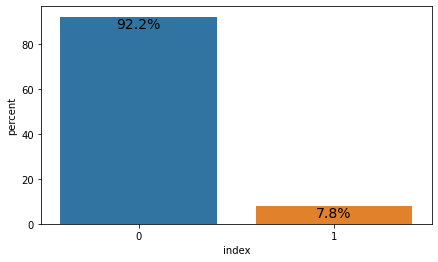

In [35]:
norm_target = application_train.TARGET.value_counts(normalize=True).mul(100).rename('percent').reset_index()

plt.figure(figsize=(7,4))
# ax = sns.barplot(x=norm_target.index, y=norm_target.values, data=norm_target)
ax = sns.barplot(x='index', y='percent', data=norm_target)

# annotate shows the values above the graphs
# in the cycle, take every bar on the graph and write the value
for patch in ax.patches:
    percentage= '{:.1f}%'.format(patch.get_height())
    ax.annotate(percentage, # text
    (patch.get_x() + patch.get_width() / 2, patch.get_height()), # set x and y for the annotation
    ha='center',
    va='top',
#     xytext=(0, 10), # with this line all the annotations are located in the same area, signatures overlap
#     textcoords='offset_points', # shift from the coordinate
    fontsize=14)

In [36]:
# # Some simple new features (percentages)
# df['DAYS_EMPLOYED_PERC'] = df['DAYS_EMPLOYED'] / df['DAYS_BIRTH']
# df['INCOME_CREDIT_PERC'] = df['AMT_INCOME_TOTAL'] / df['AMT_CREDIT']
# df['INCOME_PER_PERSON'] = df['AMT_INCOME_TOTAL'] / df['CNT_FAM_MEMBERS']
# df['ANNUITY_INCOME_PERC'] = df['AMT_ANNUITY'] / df['AMT_INCOME_TOTAL']
# df['PAYMENT_RATE'] = df['AMT_ANNUITY'] / df['AMT_CREDIT']

<AxesSubplot:>

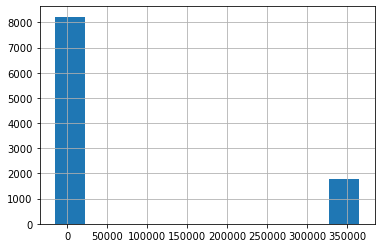

In [37]:
application_train.DAYS_EMPLOYED.hist() # a peak around 350,000

In [38]:
application_train.loc[application_train.DAYS_EMPLOYED > 50_000, 'DAYS_EMPLOYED'].value_counts() #365243 is 1,000 years

365243    1774
Name: DAYS_EMPLOYED, dtype: int64

In [39]:
application_train.loc[application_train.DAYS_EMPLOYED > 50_000, 'DAYS_EMPLOYED'] = np.nan 
# application_train.replace(365243, np.nan, inplace=True) # works as well

<AxesSubplot:>

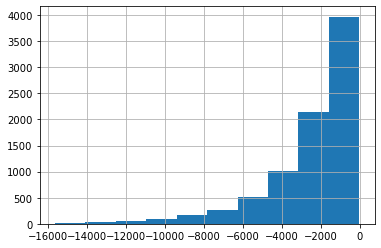

In [40]:
application_train.DAYS_EMPLOYED.hist() # How many days before the application the person started current employment

<AxesSubplot:>

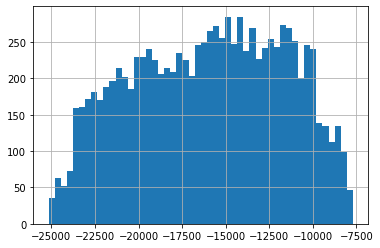

In [41]:
application_train.DAYS_BIRTH.hist(bins=50) # Client's age in days at the time of application

In [42]:
#age in years
print(application_train.DAYS_BIRTH.min() / 365.25)
print(application_train.DAYS_BIRTH.max() / 365.25)
# age in years is correct, but is given in negative numbers

-68.88432580424367
-21.09514031485284


In [43]:
#last/current job duration in years
print(application_train.DAYS_EMPLOYED.min() / 365.25)
print(application_train.DAYS_EMPLOYED.max() / 365.25)
# job duration in years is correct, but is given in negative numbers

-42.79808350444901
-0.04654346338124572


Will it not be easier if I just multiply the age of the client and the job duration to -1 ? Maybe it will break the interactions with other variables, which relate on the fact that these two variables are negative? For the moment I will not multiply them by -1, I will only take an account of it in the exploratory phase

In [44]:
# application_train[application_train.DAYS_EMPLOYED < application_train.DAYS_BIRTH] # correct: empty, as should be

# minimal age when a client started the last/current job
print((min(application_train.DAYS_EMPLOYED - application_train.DAYS_BIRTH)) / 365.25)
# maximal age when a client started the last/current job
print((max(application_train.DAYS_EMPLOYED - application_train.DAYS_BIRTH)) / 365.25)

17.924709103353866
66.99794661190965


<AxesSubplot:>

<AxesSubplot:>

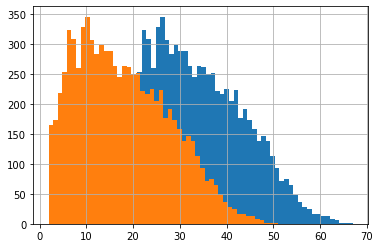

In [45]:
# to start the count from 16 years (or 5844 days), the minimal age when a person is allowed to work
display(((application_train.DAYS_EMPLOYED - application_train.DAYS_BIRTH) / 365.25).hist(bins=50))
display(((application_train.DAYS_EMPLOYED - application_train.DAYS_BIRTH - 5844) / 365.25).hist(bins=50))
# apparently no need to to such a substraction. It will be done automatically at StandardScaler step

<AxesSubplot:>

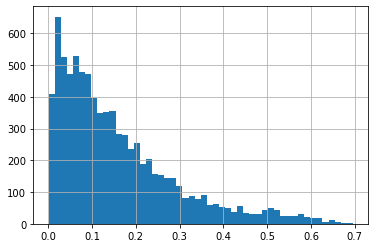

In [46]:
(application_train['DAYS_EMPLOYED'] / application_train['DAYS_BIRTH']).hist(bins=50)

## Other tables than "application train"

In [47]:
HomeCredit_columns_description.loc[HomeCredit_columns_description.Table == 'bureau_balance.csv', ['Row', 'Description']]
# pd.reset_option('max_rows')

,Row,Description
139,SK_BUREAU_ID,Recoded ID of Credit Bureau credit (unique coding for each application) - use this to join to CREDIT_BUREAU table
140,MONTHS_BALANCE,Month of balance relative to application date (-1 means the freshest balance date)
141,STATUS,"Status of Credit Bureau loan during the month (active, closed, DPD0-30, [C means closed, X means status unknown, 0 means no DPD, 1 means maximal did during month between 1-30, 2 means DPD 31-60, 5 means DPD 120+ or sold or written off ] )"


In [48]:
# bureau_balance = pd.read_csv(path_csvs + 'bureau_balance.csv', nrows=10_000)
bureau_balance = pd.read_csv(path_csvs + 'bureau_balance.csv')
bureau_balance.info()
# bureau_balance.STATUS.value_counts(dropna=False) # no NaNs
# bureau_balance.STATUS.isna().sum() # 0, no NaNs

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27299925 entries, 0 to 27299924
Data columns (total 3 columns):
 #   Column          Dtype 
---  ------          ----- 
 0   SK_ID_BUREAU    int64 
 1   MONTHS_BALANCE  int64 
 2   STATUS          object
dtypes: int64(2), object(1)
memory usage: 624.8+ MB


<AxesSubplot:>

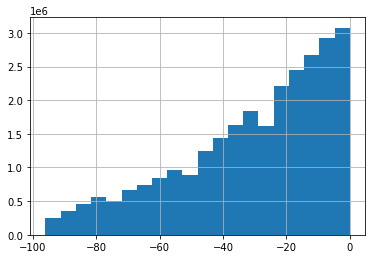

In [49]:
bureau_balance.MONTHS_BALANCE.hist(bins=20)

In [50]:
bureau_balance.STATUS.value_counts()

C    13646993
0     7499507
X     5810482
1      242347
5       62406
2       23419
3        8924
4        5847
Name: STATUS, dtype: int64

In [51]:
HomeCredit_columns_description.loc[HomeCredit_columns_description.Table == 'bureau.csv', ['Row', 'Description']]
# pd.reset_option('max_rows')

,Row,Description
122,SK_ID_CURR,"ID of loan in our sample - one loan in our sample can have 0,1,2 or more related previous credits in credit bureau"
123,SK_BUREAU_ID,Recoded ID of previous Credit Bureau credit related to our loan (unique coding for each loan application)
124,CREDIT_ACTIVE,Status of the Credit Bureau (CB) reported credits
125,CREDIT_CURRENCY,Recoded currency of the Credit Bureau credit
126,DAYS_CREDIT,How many days before current application did client apply for Credit Bureau credit
127,CREDIT_DAY_OVERDUE,Number of days past due on CB credit at the time of application for related loan in our sample
128,DAYS_CREDIT_ENDDATE,Remaining duration of CB credit (in days) at the time of application in Home Credit
129,DAYS_ENDDATE_FACT,Days since CB credit ended at the time of application in Home Credit (only for closed credit)
130,AMT_CREDIT_MAX_OVERDUE,Maximal amount overdue on the Credit Bureau credit so far (at application date of loan in our sample)
131,CNT_CREDIT_PROLONG,How many times was the Credit Bureau credit prolonged


In [52]:
# bureau = pd.read_csv(path_csvs + 'bureau.csv', nrows=10_000)
bureau = pd.read_csv(path_csvs + 'bureau.csv')
bureau.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1716428 entries, 0 to 1716427
Data columns (total 17 columns):
 #   Column                  Dtype  
---  ------                  -----  
 0   SK_ID_CURR              int64  
 1   SK_ID_BUREAU            int64  
 2   CREDIT_ACTIVE           object 
 3   CREDIT_CURRENCY         object 
 4   DAYS_CREDIT             int64  
 5   CREDIT_DAY_OVERDUE      int64  
 6   DAYS_CREDIT_ENDDATE     float64
 7   DAYS_ENDDATE_FACT       float64
 8   AMT_CREDIT_MAX_OVERDUE  float64
 9   CNT_CREDIT_PROLONG      int64  
 10  AMT_CREDIT_SUM          float64
 11  AMT_CREDIT_SUM_DEBT     float64
 12  AMT_CREDIT_SUM_LIMIT    float64
 13  AMT_CREDIT_SUM_OVERDUE  float64
 14  CREDIT_TYPE             object 
 15  DAYS_CREDIT_UPDATE      int64  
 16  AMT_ANNUITY             float64
dtypes: float64(8), int64(6), object(3)
memory usage: 222.6+ MB


In [53]:
bureau.CREDIT_ACTIVE.value_counts()

Closed      1079273
Active       630607
Sold           6527
Bad debt         21
Name: CREDIT_ACTIVE, dtype: int64

In [54]:
bureau.CREDIT_CURRENCY.value_counts()

currency 1    1715020
currency 2       1224
currency 3        174
currency 4         10
Name: CREDIT_CURRENCY, dtype: int64

In [55]:
bureau.CREDIT_TYPE.value_counts()

Consumer credit                                 1251615
Credit card                                      402195
Car loan                                          27690
Mortgage                                          18391
Microloan                                         12413
Loan for business development                      1975
Another type of loan                               1017
Unknown type of loan                                555
Loan for working capital replenishment              469
Cash loan (non-earmarked)                            56
Real estate loan                                     27
Loan for the purchase of equipment                   19
Loan for purchase of shares (margin lending)          4
Mobile operator loan                                  1
Interbank credit                                      1
Name: CREDIT_TYPE, dtype: int64

In [56]:
bureau.groupby('SK_ID_CURR')['CREDIT_TYPE'].agg('nunique').value_counts()

2    166653
1    109315
3     27652
4      2113
5        74
6         4
Name: CREDIT_TYPE, dtype: int64

Most of clients take more than 1 credit type. So we can't aggregate with "first" or "last" - we'd loose too much information. So we have to use get dummies for that.

In [57]:
bureau_balance = pd.get_dummies(bureau_balance)
bureau_balance_aggregations = {'MONTHS_BALANCE': 'count'}
for col in bureau_balance.columns[2:]:
    bureau_balance_aggregations[col] = 'sum'
bureau_balance_agg = bureau_balance.groupby('SK_ID_BUREAU').agg(bureau_balance_aggregations)

bureau = bureau.join(bureau_balance_agg, how='left', on='SK_ID_BUREAU')
bureau.drop(['SK_ID_BUREAU'], axis=1, inplace= True)
del bureau_balance, bureau_balance_agg
gc.collect()
bureau.info()

# Bureau numeric features
num_aggregations = {
    'DAYS_CREDIT': 'min', # mean ?
    'CREDIT_DAY_OVERDUE': 'mean', # also max? see AMT_CREDIT_MAX_OVERDUE
    'DAYS_CREDIT_ENDDATE': 'max',
    'DAYS_ENDDATE_FACT': 'max', # only for closed credits
    'AMT_CREDIT_MAX_OVERDUE': 'max',
    'CNT_CREDIT_PROLONG': 'sum',
    'AMT_CREDIT_SUM': 'sum',
    'AMT_CREDIT_SUM_DEBT': 'sum',
    'AMT_CREDIT_SUM_LIMIT': 'sum',
    'AMT_CREDIT_SUM_OVERDUE': 'sum',
    'DAYS_CREDIT_UPDATE': 'mean', # add max? var? like ['mean', 'var']. or 'min' is more important than 'max'?
    'AMT_ANNUITY': 'mean', # AMT_ANNUITY already exists in application_train. is it the same or different?
    'MONTHS_BALANCE': 'size'
    }
# # Bureau and bureau_balance categorical features

bureau = pd.get_dummies(bureau)
cat_aggregations = {}
for col in bureau.columns[14:]: # 16 columns before 'STATUS' starts - 2 columns "object"
    cat_aggregations[col] = 'sum'
bureau_agg = bureau.groupby('SK_ID_CURR').agg({**num_aggregations, **cat_aggregations})
print(bureau_agg.columns)
bureau_agg.rename(columns={'AMT_ANNUITY': 'AMT_ANNUITY_bureau'}, inplace=True)

# Bureau: Active credits - using only numerical aggregations
# Bureau: Closed credits - using only numerical aggregations

application_train = application_train.join(bureau_agg, how='left', on='SK_ID_CURR')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1716428 entries, 0 to 1716427
Data columns (total 25 columns):
 #   Column                  Dtype  
---  ------                  -----  
 0   SK_ID_CURR              int64  
 1   CREDIT_ACTIVE           object 
 2   CREDIT_CURRENCY         object 
 3   DAYS_CREDIT             int64  
 4   CREDIT_DAY_OVERDUE      int64  
 5   DAYS_CREDIT_ENDDATE     float64
 6   DAYS_ENDDATE_FACT       float64
 7   AMT_CREDIT_MAX_OVERDUE  float64
 8   CNT_CREDIT_PROLONG      int64  
 9   AMT_CREDIT_SUM          float64
 10  AMT_CREDIT_SUM_DEBT     float64
 11  AMT_CREDIT_SUM_LIMIT    float64
 12  AMT_CREDIT_SUM_OVERDUE  float64
 13  CREDIT_TYPE             object 
 14  DAYS_CREDIT_UPDATE      int64  
 15  AMT_ANNUITY             float64
 16  MONTHS_BALANCE          float64
 17  STATUS_0                float64
 18  STATUS_1                float64
 19  STATUS_2                float64
 20  STATUS_3                float64
 21  STATUS_4                float64

In [58]:
# credit_card_balance = pd.read_csv(path_csvs + 'credit_card_balance.csv')
# credit_card_balance.info()

In [59]:
# installments_payments = pd.read_csv(path_csvs + 'installments_payments.csv')
# installments_payments.info()

In [60]:
# POS_CASH_balance = pd.read_csv(path_csvs + 'POS_CASH_balance.csv')
# POS_CASH_balance.info()

In [61]:
# previous_application = pd.read_csv(path_csvs + 'previous_application.csv')
# previous_application.info()

In [62]:
# previous_application.select_dtypes(include='object').info()

In [63]:
# sample_submission = pd.read_csv(path_csvs + 'sample_submission.csv')
# sample_submission.info()

In [64]:
pd.reset_option("max_rows")
pd.get_option("max_rows")

60

In [65]:
# %who_ls

The variables accumulated by now:

DummyClassifier, GridSearchCV, HomeCredit_columns_description, KFold, LGBMClassifier, LogisticRegression, LogisticRegressionCV, OneHotEncoder, PassiveAggressiveClassifier, RandomForestClassifier, StandardScaler, StratifiedKFold, application_train, auc, ax, bureau, bureau_agg, bureau_balance_aggregations, cat_aggregations, category_to_fail_proportion, classification_report, col, confusion_matrix, contextmanager, f1_score, find_most_risky, gc, imblearn, list_files, listdir, make_column_transformer, make_pipeline, make_scorer, norm_target, np, num_aggregations, patch, path_csvs, pd, percentage, plt, precision_score, rasta, recall_score, roc_auc_score, roc_curve, selectcol, selectcol_full, sklearn, sns, test, test1, test2, test_df, test_t, time, train_test_split, warnings

Variables selected for deletion:

ax, bureau, bureau_agg, bureau_balance_aggregations, cat_aggregations, col, contextmanager, norm_target, num_aggregations, patch, percentage, selectcol, selectcol_full,  test, test1, test2, test_df, test_t

In [66]:
del ax, bureau, bureau_agg, bureau_balance_aggregations, cat_aggregations, col, contextmanager, norm_target
del num_aggregations, patch, percentage, selectcol, selectcol_full,  test, test1, test2, test_df, test_t
gc.collect()

2642

In [67]:
gc.collect()

0

# Data cleaning

The simplest cleaning consist of remove all the columns that have NaN values, then keeping only the columns that have 2 or 3 unique values. If we have more than 10 dimensions, we can test it as a dummy model.

In [68]:
application_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Columns: 166 entries, SK_ID_CURR to CREDIT_TYPE_Unknown type of loan
dtypes: float64(110), int64(40), object(16)
memory usage: 12.7+ MB


In [69]:
# how many NaNs, percentage
for col in application_train.select_dtypes(include=object):
    print(col, application_train[col].isna().sum() / application_train.shape[0] * 100)

NAME_CONTRACT_TYPE 0.0
CODE_GENDER 0.0
FLAG_OWN_CAR 0.0
FLAG_OWN_REALTY 0.0
NAME_TYPE_SUITE 0.0
NAME_INCOME_TYPE 0.0
NAME_EDUCATION_TYPE 0.0
NAME_FAMILY_STATUS 0.0
NAME_HOUSING_TYPE 0.0
OCCUPATION_TYPE 0.0
WEEKDAY_APPR_PROCESS_START 0.0
ORGANIZATION_TYPE 0.0
FONDKAPREMONT_MODE 0.0
HOUSETYPE_MODE 0.0
WALLSMATERIAL_MODE 0.0
EMERGENCYSTATE_MODE 0.0


In [70]:
# how many NaNs, percentage
for col in application_train.select_dtypes(include=int):
    print(col, application_train[col].isna().sum() / application_train.shape[0] * 100)

SK_ID_CURR 0.0
TARGET 0.0
CNT_CHILDREN 0.0
DAYS_BIRTH 0.0
DAYS_ID_PUBLISH 0.0
FLAG_MOBIL 0.0
FLAG_EMP_PHONE 0.0
FLAG_WORK_PHONE 0.0
FLAG_CONT_MOBILE 0.0
FLAG_PHONE 0.0
FLAG_EMAIL 0.0
REGION_RATING_CLIENT 0.0
REGION_RATING_CLIENT_W_CITY 0.0
HOUR_APPR_PROCESS_START 0.0
REG_REGION_NOT_LIVE_REGION 0.0
REG_REGION_NOT_WORK_REGION 0.0
LIVE_REGION_NOT_WORK_REGION 0.0
REG_CITY_NOT_LIVE_CITY 0.0
REG_CITY_NOT_WORK_CITY 0.0
LIVE_CITY_NOT_WORK_CITY 0.0
FLAG_DOCUMENT_2 0.0
FLAG_DOCUMENT_3 0.0
FLAG_DOCUMENT_4 0.0
FLAG_DOCUMENT_5 0.0
FLAG_DOCUMENT_6 0.0
FLAG_DOCUMENT_7 0.0
FLAG_DOCUMENT_8 0.0
FLAG_DOCUMENT_9 0.0
FLAG_DOCUMENT_10 0.0
FLAG_DOCUMENT_11 0.0
FLAG_DOCUMENT_12 0.0
FLAG_DOCUMENT_13 0.0
FLAG_DOCUMENT_14 0.0
FLAG_DOCUMENT_15 0.0
FLAG_DOCUMENT_16 0.0
FLAG_DOCUMENT_17 0.0
FLAG_DOCUMENT_18 0.0
FLAG_DOCUMENT_19 0.0
FLAG_DOCUMENT_20 0.0
FLAG_DOCUMENT_21 0.0


In [71]:
# how many NaNs, percentage
for col in application_train.select_dtypes(include=float):
    print(col, application_train[col].isna().sum() / application_train.shape[0] * 100)

AMT_INCOME_TOTAL 0.0
AMT_CREDIT 0.0
AMT_ANNUITY 0.0
AMT_GOODS_PRICE 0.06999999999999999
REGION_POPULATION_RELATIVE 0.0
DAYS_EMPLOYED 17.740000000000002
DAYS_REGISTRATION 0.0
OWN_CAR_AGE 66.62
CNT_FAM_MEMBERS 0.0
EXT_SOURCE_1 56.47
EXT_SOURCE_2 0.26
EXT_SOURCE_3 19.950000000000003
APARTMENTS_AVG 50.64999999999999
BASEMENTAREA_AVG 58.160000000000004
YEARS_BEGINEXPLUATATION_AVG 48.8
YEARS_BUILD_AVG 66.4
COMMONAREA_AVG 69.78999999999999
ELEVATORS_AVG 53.09
ENTRANCES_AVG 50.06
FLOORSMAX_AVG 49.43
FLOORSMIN_AVG 67.95
LANDAREA_AVG 58.98
LIVINGAPARTMENTS_AVG 68.45
LIVINGAREA_AVG 50.09
NONLIVINGAPARTMENTS_AVG 69.42
NONLIVINGAREA_AVG 54.779999999999994
APARTMENTS_MODE 50.64999999999999
BASEMENTAREA_MODE 58.160000000000004
YEARS_BEGINEXPLUATATION_MODE 48.8
YEARS_BUILD_MODE 66.4
COMMONAREA_MODE 69.78999999999999
ELEVATORS_MODE 53.09
ENTRANCES_MODE 50.06
FLOORSMAX_MODE 49.43
FLOORSMIN_MODE 67.95
LANDAREA_MODE 58.98
LIVINGAPARTMENTS_MODE 68.45
LIVINGAREA_MODE 50.09
NONLIVINGAPARTMENTS_MODE 69.42
NON

In [72]:
# application_train = application_train.fillna(0)
application_train = application_train.fillna(application_train.median())

# data_cleaned = application_train.dropna(axis=1).copy()
# data_cleaned.info()

Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.


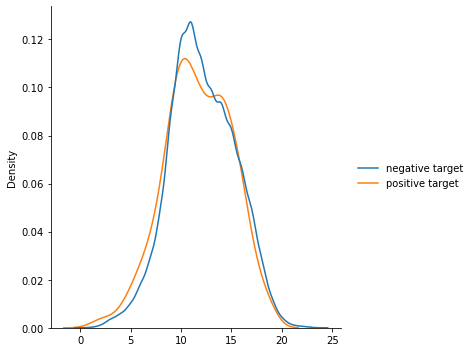

In [73]:
sns.displot({'negative target': application_train[application_train.TARGET == 0].HOUR_APPR_PROCESS_START,
    'positive target': application_train[application_train.TARGET == 1].HOUR_APPR_PROCESS_START},
    kind='kde', common_norm=False) #independent normalization for each subset

# there are 50 bins by default, no?

according to histogram it makes sense to include HOUR_APPR_PROCESS_START column in the account. But the correlation isn't linear.

In [74]:
# data_cleaned = data_cleaned.drop(['WEEKDAY_APPR_PROCESS_START', 'HOUR_APPR_PROCESS_START'], axis=1)

# data_cleaned = data_cleaned.drop(['WEEKDAY_APPR_PROCESS_START'], axis=1)

application_train = application_train.drop(['WEEKDAY_APPR_PROCESS_START'], axis=1)


# Plan of work with models

1. Train-test split, do it once, and make all the later comparisons on the same splitting. The random state is selected in the beginning of the notebook as rasta.
2. Test with DummyClassifier, to see what are the metrics for the predictions unrelated to the data (but related to the target).
2. Build the preprocessor (standardscaler for numeric, onehotencoder for categorical).
3. Take into account the method of imbalanced classes handling: it can be class_weight="balanced" parameter of the model/estimator, or it can be simple SMOTE (oversampling, generation of new samples); here I don't try the option of SMOTE followed by undersampling (like Tomek Links or ENN).  
In fact, you can't insert the SMOTE step into your pipeline, because the pipeline is a fixed sequence of steps, and I want SMOTE to be the optional/conditional step, because it depends whether I use SMOTE or class_weight='balanced'. So, I can either make two different pipelines - with SMOTE step present and skipped, or I can not make the pipeline at all - just use the transformed X_train and y_train, transformed with the preprocessor.  
3. With the help of cross-validation, select the best model(LogReg, RandForest, PassAgressive, LightGBM), the best parameters (different for each model, are given in advance with a dictionart that will be passed to param_grid), the best conditions of imbalanced class handling. At this step I use the roc-auc score: the best model and combination of parameters is the one with highest AUC. I will display the personalized metric as well, but only for observation. The refitting of the models is on roc_auc on this step, and the best_params_ are defined according to the highest roc_auc.

4. Then I take the model that was found to be the best according to roc_auc (now I know it is LogReg 2022-01-25), and use this model for further tests. I make the tests on only this model, but I look for the best parameters and the best conditions of imbalanced class handling according to my personalized metric, that I define myself (I use 10 * False_neg + 1 * False_pos).

5. Once the best parameters are found for this personalized metric, be they the same as with roc_auc or different, I take these new parameters and train my model with them.  
For this final training I don't need a cross-validation any more. So, I will make a new pipeline, with preprocessor, (then maybe SMOTE, if it works better than class_weight='balanced' in the model), then the model. This way the model is trained on 80% of the data, not on 64% as during cross-validation.

# Train test split

Stratified train test split which preserves the proportion of negative and positive as in whe whole dataset (8% positives in both train split and test split)

In [75]:
# data_train, data_test = train_test_split(data_cleaned, test_size=0.2, random_state = rasta, stratify=data_cleaned.TARGET)
data_train, data_test = train_test_split(application_train, test_size=0.2, random_state = rasta, stratify=application_train.TARGET)


In [76]:
X_train = data_train.drop('TARGET', axis=1)
X_test = data_test.drop('TARGET', axis=1)
y_train = data_train.TARGET.values
y_test = data_test.TARGET.values

# X_full = data_cleaned.drop('TARGET', axis=1)

X_full = application_train.drop('TARGET', axis=1)

In [77]:
print(f'X train: {X_train.shape}, X test: {X_test.shape}, y train: {y_train.shape}, y train: {y_test.shape}, ')

X train: (8000, 164), X test: (2000, 164), y train: (8000,), y train: (2000,), 


In [78]:
print(len(y_test), "test values")
print(y_test.sum(), "positive values in test set")
print(y_test.sum() / len(y_test) * 100, 'proportion of positive values, percentage')

2000 test values
155 positive values in test set
7.75 proportion of positive values, percentage


# Dummy classifier accuracy

We work with a database which has a major and a minor class, where the detection of the minor class is super-important. Let's call the minor class (fail to pay the credit) positive, and major class (manages to pay the credit) negative.
Then the dummy classifier will always predict the negative class.

The DummyClassifier Method in Scikit Learn uses "prior" strategy. The "predict" method always returns the most frequent class label in the observed y argument passed to fit (like "most_frequent). 

The "predict_proba" always returns the empirical class distribution of y also known as the empirical class prior distribution. In our case it means it will return the probabiliteis proportionally to what it have seen at fitting stage: 92% negative, 8% positive.

Meanwhile the "predict_proba" with "most_frequent" strategy returns the matching one-hot encoded vector, which means vector composed of 0s in our case or of 1s.

In [79]:
dummy_clf = DummyClassifier(strategy='prior')
dummy_clf.fit(X_train, y_train)
dummy_pred = dummy_clf.predict(X_test)
print(dummy_clf.score(X_test, y_test))

0.9225


As we see, the dummy classifier has 92% accuracy.

The metric that interests us, is how much of positives are correctly detected. How much of the positives are true positives. How much of negatives are false negatives. The objective is to have as few false negatives as possible.

Precision allows not to mark a reliable client as a suspicious one. HIgher the precision, better this probability is. 
It shows how many clients are really failsome, out of predicted as such.

Recall allows not to mark a suspicious client as a reliable one. This metric is essential, the priority should be given to it. It shows how many positives were picked up and not missed, out of all existing failsome clients.

From the other hand, an algoritm that marks everyone as suspicious, would have 100% of recall, but have bad other metrics, and would be a useless model. So the balance should be found between the recall and other metrics (like precision or maybe others).

The balance can be found with 1F score.

# Best model selection by CV (cross-validation)
using exhaustive grid search with GridsearchCV

In [80]:
errors = []
perso_errors=[]

In [81]:
def compare_model(my_estimator, model_name, my_params={}, smote=False, perso=False):
    
    if smote:
#         model = make_pipeline(preprocessor, SMOTE(random_state=rasta_smote), my_estimator) # TypeError: All intermediate steps should be transformers and implement fit and transform or be the string 'passthrough' 'SMOTE(random_state=1)' (type <class 'imblearn.over_sampling._smote.base.SMOTE'>) doesn't
        model = make_pipeline_imblearn(preprocessor, SMOTE(random_state=rasta_smote), my_estimator)
    else:
        model = make_pipeline(preprocessor, 'passthrough', my_estimator)
#         print(model.steps[1]) # for getting the name of the model: eventually it equals the EstimatorName.lower()

    if perso:
#         scoring = my_scoring # my_scorer, also works, if you uncomment the line. search "my_scorer ="
#         refit='roc_auc' # temporary for debugging, to show that the problem isn't in the metric or scorer
#         refit=my_scoring['perso'] #TypeError: __call__() missing 2 required positional arguments: 'X' and 'y_true'
        refit='perso'

    else:
#         scoring = ['roc_auc', 'recall', 'precision']
        refit='roc_auc'
#         refit=False # AttributeError: 'GridSearchCV' object has no attribute 'best_params_'. For multi-metric evaluation, best_params_ is present only if refit is specified

    grid = GridSearchCV(  # if you envelop the pipleine in the gridsearch, you must adress every hyperparameter as estimator__ParameterName                       estimator=my_estimator, 
                      estimator=model, # moreover, you can't call the "my_estimator", you must call it with its proper name, i.e. "passiveaggressiveclassifier__C"
                      param_grid=my_params, 
                      cv=5, 
#                       scoring=scoring, 
#                       scoring='roc_auc', 
                      scoring=my_scoring, 
                      return_train_score = True, 
                      refit=refit, #'roc_auc', 
                      n_jobs = -1)
    
    time1 = time()
    print('Fitting started')
#     model.fit(X_train, y_train)
#     model = model.fit(X_train, y_train)
    grid = grid.fit(X_train, y_train)
    time2 = time()
    print('Cross-validation of model', model_name, 'completed in', time2 - time1, 'seconds')
#     print('best params:', model[1].best_params_)
    print('best params:', grid.best_params_)
#     results = model[1].cv_results_
    results = grid.cv_results_
    
#     y_pred = model.predict(X_test) # NotFittedError: This ColumnTransformer instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.
    y_pred = grid.predict(X_test)
    
#     if perso:
#         my_metric = results['mean_train_perso'].max().round(3)
#     else:
#         my_metric = np.nan

    errors.append([model_name, 'cv_train', smote, 
#                    my_metric,
               results['mean_train_perso'].max().round(3),    
               results['mean_train_roc_auc'].max().round(3),
               results['mean_train_recall'].max().round(3),
               results['mean_train_precision'].max().round(3)])

#     if perso:
#         my_metric = results['mean_test_perso'].max().round(3)

    errors.append([model_name, 'cv_test', smote, 
#                    my_metric,
               results['mean_test_perso'].max().round(3),
               results['mean_test_roc_auc'].max().round(3),
               results['mean_test_recall'].max().round(3),
               results['mean_test_precision'].max().round(3)])

#     if perso:
#         my_metric = -personalized_metric(y_test, y_pred).round(3)

    errors.append([model_name, 'external_test', smote, 
#                   my_metric,
               -personalized_metric(y_test, y_pred).round(3),
               roc_auc_score(y_test, y_pred).round(3),
               recall_score(y_test, y_pred).round(3),
               precision_score(y_test, y_pred).round(3)])
    
    time3 = time()
    print('Prediction and evaluation completed in', time3 - time2, 'seconds')
    
    return model, y_pred, grid.best_params_
    

In [82]:
preprocessor = make_column_transformer(
    (StandardScaler(),
     X_full.select_dtypes(include=['int64','float64']).columns),
    (OneHotEncoder
     (categories = [X_full[feature].unique() for feature in X_full.select_dtypes(exclude=['int64','float64']).columns],
      drop='first'),
     X_full.select_dtypes(exclude=['int64','float64']).columns), remainder='passthrough')

# Personalized metric: 10 * False Neg + False Pos

In [83]:
# print(sorted(sklearn.metrics.SCORERS.keys()))
# sklearn.metrics.SCORERS

In [84]:
print(sum((y_test == 1) & (dummy_pred == 1))) # True Pos
print(sum((y_test == 0) & (dummy_pred == 0))) # True Neg
print(sum((y_test == 1) & (dummy_pred == 0))) # False Neg
print(sum((y_test == 0) & (dummy_pred == 1))) # False Pos

0
1845
155
0


In [85]:
def personalized_metric(y_true, y_pred, false_neg_coef=10, false_pos_coef=1):
    cm = confusion_matrix(y_true, y_pred) # {'tn': cm[0, 0], 'fp': cm[0, 1], 'fn': cm[1, 0], 'tp': cm[1, 1]}
    false_neg_coef * cm[1, 0] + false_pos_coef * cm[0, 1]
    return (false_neg_coef * cm[1, 0] + false_pos_coef * cm[0, 1]) / len(y_true)

my_scorer = make_scorer(personalized_metric, greater_is_better=False)

# my_scoring = {'perso': make_scorer(personalized_metric, greater_is_better=False)}
# my_scoring = {'perso': my_scorer),
my_scoring = {'perso': my_scorer, 'roc_auc': 'roc_auc', 'recall': 'recall', 'precision': 'precision'}

Train the model with the best AUC, but this time choose the personalized metric for best parameter selection.

The best model at the moment is LogisticRegression, but I can't get out the features. Maybe it's because the model doesn't refit correctly. I have set refit='roc_auc' temùporarily for debugging, but I still can't pull the coefficients out.

I will check if I can pull out the feature importances for other models, even though they are not leaders in roc_auc evaluation.

# Addition of different models and conditions to comparison table

## Baseline: DummyClassifier that always predicts major class

In [86]:
aaa, dummy_pred, bbb = compare_model(DummyClassifier(strategy='prior'), 'Dummy')
del aaa, bbb

Fitting started
Cross-validation of model Dummy completed in 4.6498565673828125 seconds
best params: {}
Prediction and evaluation completed in 0.03099989891052246 seconds


Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.


## With "class_weight = 'balanced' imbalanced classes handling

In [87]:
params_to_compare = {'passiveaggressiveclassifier__C': np.logspace(-4, 0, 5)}, # (-4, 4, 7) with (-2, 2, 3) best params: {'C': 1.0}

model_PassAggr, pred_PassAggr, best_params_PassAggr = compare_model(PassiveAggressiveClassifier(class_weight='balanced', 
                                random_state=rasta_class, max_iter=10_000), 'PassAggr', params_to_compare)

Fitting started
Cross-validation of model PassAggr completed in 4.7085912227630615 seconds
best params: {'passiveaggressiveclassifier__C': 0.0001}
Prediction and evaluation completed in 0.03700566291809082 seconds


In [88]:
# smaller C means stronger regularization
# Cs as integer provides equally distributed C from 10^-4 to 10^4
# model = make_pipeline(preprocessor, LogisticRegression(tol=0.01, max_iter=1000))

params_to_compare = {'logisticregression__C': np.logspace(-4, 0, 5)}, # (-4, -1, 3)

model_LogReg, pred_LogReg, best_params_LogReg = compare_model(LogisticRegression(class_weight='balanced',
                                           tol=0.001, random_state=rasta_class, 
                                           max_iter=10_000), 'LogReg', params_to_compare)

Fitting started
Cross-validation of model LogReg completed in 9.175062656402588 seconds
best params: {'logisticregression__C': 0.001}
Prediction and evaluation completed in 0.029999256134033203 seconds


In [89]:
params_to_compare = {'randomforestclassifier__n_estimators': [100, 200, 400, 600], # [100, 200, 400, 600]
             'randomforestclassifier__min_impurity_decrease': [0, 0.1], 
             }


model_Forest, pred_Forest, best_params_Forest = compare_model(RandomForestClassifier(class_weight='balanced',
                                                random_state=rasta_class), 'Forest', params_to_compare)

Fitting started
Cross-validation of model Forest completed in 65.23664855957031 seconds
best params: {'randomforestclassifier__min_impurity_decrease': 0, 'randomforestclassifier__n_estimators': 600}
Prediction and evaluation completed in 0.3870279788970947 seconds


## With SMOTE imbalanced classes handling

In [90]:
params_to_compare = {'passiveaggressiveclassifier__C': np.logspace(-2, 2, 5)}

model_PassAggr, pred_PassAggr, best_params_PassAggr = compare_model(PassiveAggressiveClassifier(max_iter=10_000, 
                                random_state=rasta_class), 'PassAggr', params_to_compare, smote=True)

Fitting started
Cross-validation of model PassAggr completed in 5.905536890029907 seconds
best params: {'passiveaggressiveclassifier__C': 0.01}
Prediction and evaluation completed in 0.0350031852722168 seconds


In [91]:
# smaller C means stronger regularization
# Cs as integer provides equally distributed C from 10^-4 to 10^4
# model = make_pipeline(preprocessor, LogisticRegression(tol=0.01, max_iter=1000))

params_to_compare = {'logisticregression__C': np.logspace(-4, 2, 7)}, # (-4, -1, 3)

model_LogReg, pred_LogReg, best_params_LogReg = compare_model(LogisticRegression(
                                           tol=0.001, 
                                           max_iter=10_000), 'LogReg', params_to_compare, smote=True)

Fitting started
Cross-validation of model LogReg completed in 52.29325032234192 seconds
best params: {'logisticregression__C': 0.001}
Prediction and evaluation completed in 0.031000375747680664 seconds


In [92]:
params_to_compare = {'randomforestclassifier__n_estimators': [100, 200, 400, 600], # [100, 200, 400, 600]
             'randomforestclassifier__min_impurity_decrease': [0, 0.1] 
             }


model_Forest, pred_Forest, best_params_Forest = compare_model(RandomForestClassifier(),
                                                            'Forest', params_to_compare, smote=True)

Fitting started
Cross-validation of model Forest completed in 130.2837233543396 seconds
best params: {'randomforestclassifier__min_impurity_decrease': 0, 'randomforestclassifier__n_estimators': 600}
Prediction and evaluation completed in 0.3740103244781494 seconds


In [93]:
errors

[['Dummy', 'cv_train', False, -0.775, 0.5, 0.0, 0.0],
 ['Dummy', 'cv_test', False, -0.775, 0.5, 0.0, 0.0],
 ['Dummy', 'external_test', False, -0.775, 0.5, 0.0, 0.0],
 ['PassAggr', 'cv_train', False, -0.472, 0.792, 0.728, 0.18],
 ['PassAggr', 'cv_test', False, -0.541, 0.744, 0.639, 0.16],
 ['PassAggr', 'external_test', False, -0.52, 0.69, 0.652, 0.168],
 ['LogReg', 'cv_train', False, -0.437, 0.82, 0.757, 0.191],
 ['LogReg', 'cv_test', False, -0.538, 0.745, 0.65, 0.16],
 ['LogReg', 'external_test', False, -0.514, 0.695, 0.665, 0.169],
 ['Forest', 'cv_train', False, 0.0, 1.0, 1.0, 1.0],
 ['Forest', 'cv_test', False, -0.773, 0.73, 0.4, 0.3],
 ['Forest', 'external_test', False, -0.77, 0.503, 0.006, 1.0],
 ['PassAggr', 'cv_train', True, -0.499, 0.766, 0.722, 0.165],
 ['PassAggr', 'cv_test', True, -0.632, 0.664, 0.576, 0.129],
 ['PassAggr', 'external_test', True, -0.582, 0.657, 0.652, 0.139],
 ['LogReg', 'cv_train', True, -0.445, 0.812, 0.727, 0.195],
 ['LogReg', 'cv_test', True, -0.545, 0.73

In [94]:
df_results = pd.DataFrame(errors, columns=['Model', 'Source', 'SMOTE', 'Perso', 'AUC', 'Recall', 'Precision'])

In [95]:
display(df_results[df_results.Source == 'cv_train'].sort_values(by='AUC', ascending=False).head(2))
display(df_results[df_results.Source == 'cv_test'].sort_values(by='AUC', ascending=False).head(2))
display(df_results[df_results.Source == 'external_test'].sort_values(by='AUC', ascending=False).head(2))
# fillna median cv=5

,Model,Source,SMOTE,Perso,AUC,Recall,Precision
9,Forest,cv_train,False,0.0,1.0,1.0,1.0
18,Forest,cv_train,True,0.0,1.0,1.0,1.0


,Model,Source,SMOTE,Perso,AUC,Recall,Precision
7,LogReg,cv_test,False,-0.538,0.745,0.650,0.16
4,PassAggr,cv_test,False,-0.541,0.744,0.639,0.16


,Model,Source,SMOTE,Perso,AUC,Recall,Precision
17,LogReg,external_test,True,-0.510,0.697,0.665,0.171
8,LogReg,external_test,False,-0.514,0.695,0.665,0.169


In [96]:
# df_results = pd.DataFrame(errors,columns=['Model', 'Source', 'SMOTE', 'Perso', 'AUC', 'Recall', 'Precision'])
display(df_results[df_results.Source == 'cv_train'].sort_values(by='Perso', ascending=False).head(2))
display(df_results[df_results.Source == 'cv_test'].sort_values(by='Perso', ascending=False).head(2))
display(df_results[df_results.Source == 'external_test'].sort_values(by='Perso', ascending=False).head(2))
display(df_results.sort_values(by='Perso').head())

,Model,Source,SMOTE,Perso,AUC,Recall,Precision
9,Forest,cv_train,False,0.0,1.0,1.0,1.0
18,Forest,cv_train,True,0.0,1.0,1.0,1.0


,Model,Source,SMOTE,Perso,AUC,Recall,Precision
7,LogReg,cv_test,False,-0.538,0.745,0.650,0.16
4,PassAggr,cv_test,False,-0.541,0.744,0.639,0.16


,Model,Source,SMOTE,Perso,AUC,Recall,Precision
17,LogReg,external_test,True,-0.510,0.697,0.665,0.171
8,LogReg,external_test,False,-0.514,0.695,0.665,0.169


,Model,Source,SMOTE,Perso,AUC,Recall,Precision
0,Dummy,cv_train,False,-0.775,0.500,0.000,0.0
1,Dummy,cv_test,False,-0.775,0.500,0.000,0.0
2,Dummy,external_test,False,-0.775,0.500,0.000,0.0
10,Forest,cv_test,False,-0.773,0.730,0.400,0.3
11,Forest,external_test,False,-0.770,0.503,0.006,1.0


We see that RandomForest is highly overfitted.

When the score was 'accuracy', the precision was 0, which meant that I have no positive predictions.

The standard methods of cross-validation don't fit, because they select the "best" parameter (what they believe to be the best) depending on the highest accuracy. Which is the highest when the model predicts only 0s.

When I changed the score to "roc_auc" based on the list of available scores, the precision is above 0, as well as the recall.

# Redo the cross-validation with personalized metric

The best model that was optimised according to roc_auc is LogisticRegression. Now we can train the model that have found to be the best, but this time we select the best parameters differently: we select it in a way that the personalized metric (cost of false positive and false negative to the bank, equalized with coefficients) is minimal. And let's see if this impacts the optimal value of the hyperparameter.

In [97]:
# smaller C means stronger regularization
# Cs as integer provides equally distributed C from 10^-4 to 10^4
# model = make_pipeline(preprocessor, LogisticRegression(tol=0.01, max_iter=1000))

params_to_compare = {'logisticregression__C': np.logspace(-4, 0, 5)}, # (-4, -1, 3)

model_LogReg, pred_LogReg, best_params_LogReg = compare_model(LogisticRegression(class_weight='balanced',
                                           tol=0.001, random_state=rasta_class, 
                                           max_iter=10_000), 'LogReg', params_to_compare, perso=True, smote=False)

Fitting started
Cross-validation of model LogReg completed in 8.696978330612183 seconds
best params: {'logisticregression__C': 0.01}
Prediction and evaluation completed in 0.029994726181030273 seconds


# Train the best model with full dataset

The best model is LogisticRegression. 

In [98]:
model_LogReg.fit(X_train, y_train)
y_pred = model_LogReg.predict(X_test)
y_pred.shape

(2000,)

In [99]:
# print(X_test.shape) # (2000, 164)
# print(model_LogReg[0].transform(X_test).shape) # (2000, 265)
# print(len(model_LogReg[0].get_feature_names_out())) # 265

In [100]:
# model_LogReg[0].get_feature_names_out()

# array(['standardscaler__SK_ID_CURR', 'standardscaler__CNT_CHILDREN',
#        'standardscaler__AMT_INCOME_TOTAL', 'standardscaler__AMT_CREDIT', ...
#        'onehotencoder__WALLSMATERIAL_MODE_Monolithic',
#        'onehotencoder__EMERGENCYSTATE_MODE_Yes'], dtype=object)

In [101]:
model_LogReg[0] # the columntransformer
model_LogReg[1] # the SMOTE or 'passthrough'
model_LogReg[2] # the classifier

LogisticRegression(class_weight='balanced', max_iter=10000, random_state=1,
                   tol=0.001)

# Predict feature values: individual predictions for a client with SHAP

In [102]:
shap.initjs()

In [103]:
# log_reg_explainer = shap.LinearExplainer(log_reg, data=X_train) # example of code

# log_reg_explainer = shap.LinearExplainer(model_LogReg, data=X_train) # TypeError: __init__() missing 1 required positional argument: 'masker'

In [104]:
# (class) shap.LinearExplainer(model, data, nsamples=1000, feature_perturbation=None, **kwargs) # signature of a class
# there's no masker parameter in the class signature

# __init__(model, data, nsamples=1000, feature_perturbation=None, **kwargs)
# there's no masker parameter in the init method

masker: function, numpy.array, pandas.DataFrame, tokenizer, or a list of these for each model input  
https://shap-lrjball.readthedocs.io/en/latest/generated/shap.LinearExplainer.html  
The function used to “mask” out hidden features of the form masked_args = masker(* model_args, mask=mask). It takes input in the same form as the model, but for just a single sample with a binary mask, then returns an iterable of masked samples. These masked samples will then be evaluated using the model function and the outputs averaged. slice() model(* masker(* args, mask=mask)).mean() As a shortcut for the standard masking using by SHAP you can pass a background data matrix instead of a function and that matrix will be used for masking. Domain specific masking functions are available in shap such as shap.ImageMasker for images and shap.TokenMasker for text. In addition to determining how to replace hidden features, the masker can also constrain the rules of the cooperative game used to explain the model. For example shap.TabularMasker(data, hclustering=”correlation”) will enforce a hierarchial clustering of coalitions for the game (in this special case the attributions are known as the Owen values).

Try to do as in the sample: I insert the logistic regression as the first argument

In [105]:
# model_LogReg[0].transform(X_train) # array  (8000, 265)
# model_LogReg[2] # LogisticRegression(class_weight='balanced', max_iter=10000, random_state=1, tol=0.001)

# log_reg_explainer = shap.LinearExplainer(log_reg, data=X_train) # example of code
# log_reg_explainer = shap.LinearExplainer(model_LogReg[2], data=X_train) # TypeError: __init__() missing 1 required positional argument: 'masker'

Try to do as in the sample: I insert the logistic regression as the first argument, and the transformed array as the second argument.

In [106]:
# model_LogReg[0].transform(X_train) # array  (8000, 265)
# model_LogReg[2] # LogisticRegression(class_weight='balanced', max_iter=10000, random_state=1, tol=0.001)

# log_reg_explainer = shap.LinearExplainer(log_reg, data=X_train) # example of code
# log_reg_explainer = shap.LinearExplainer(model_LogReg[2], data=model_LogReg[0].transform(X_train)) # TypeError: __init__() missing 1 required positional argument: 'masker'

If it doesn't work, I try to convert the train data with column transformer. And then insert into the linear explainer (logisticregression, transformed_array).

In [107]:
# trans_array = model_LogReg[0].transform(X_train)
# log_reg_explainer = shap.LinearExplainer(model_LogReg[2], data=trans_array) # TypeError: __init__() missing 1 required positional argument: 'masker'

If even that doesn't work, try to make to convert the array to the DataFrame, with the column names withdrawn with get_feature_names_out.

In [108]:
# trans_array = model_LogReg[0].transform(X_train)
# shap_feature_names = columns=model_LogReg[0].get_feature_names_out()
# df_for_shap = pd.DataFrame(trans_array, columns=shap_feature_names)

# log_reg_explainer = shap.LinearExplainer(model_LogReg[2], data=df_for_shap) # TypeError: __init__() missing 1 required positional argument: 'masker'

In [109]:
# the solution from stackoverflow

trans_array = model_LogReg[0].transform(X_train)
shap_feature_names = columns=model_LogReg[0].get_feature_names_out()
df_for_shap = pd.DataFrame(trans_array, columns=shap_feature_names)

masker = shap.maskers.Independent(data = df_for_shap)
log_reg_explainer = shap.LinearExplainer(model_LogReg[2], masker = masker)

In [110]:
sample_idx = 0
# shap_vals = log_reg_explainer.shap_values(X_test[sample_idx]) # KeyError: 0
X_test_sh = model_LogReg[0].transform(X_test)
shap_vals = log_reg_explainer.shap_values(X_test_sh[sample_idx]) # array, shape (265,)

In [111]:
# val1 = log_reg_explainer.expected_value[0] + shap_vals[0].sum() # IndexError: invalid index to scalar variable.
# log_reg_explainer.expected_value # -0.7231118051717474
# shap_vals[0] # 0.000892638121005155
val1 = log_reg_explainer.expected_value + shap_vals.sum() # 1.1964024509782871

In [112]:
# But how to do the next value?
# val2 = log_reg_explainer.expected_value[1] + shap_vals[1].sum() # IndexError: invalid index to scalar variable.

In [116]:
print("Base Value : ", log_reg_explainer.expected_value)
print("Some Shap Values for Sample %d : "%sample_idx, shap_vals[:10], len(shap_vals), 'coeffficients overall')
# print("Prediction From Adding SHAP Values to Base Value : ", wine.target_names[np.argmax([val1, val2, val3])])

Base Value :  -0.7231118051717474
Some Shap Values for Sample 0 :  [ 0.00089264 -0.05465439  0.05953911  0.16398707 -0.01437064 -0.15548776
 -0.0562792   0.0045022   0.00776056  0.03310052] 265 coeffficients overall


In [122]:
# print("Prediction From Model:", lin_reg.predict(X_test[sample_idx].reshape(1,-1))[0])
# print("Prediction From Model:", \ wine.target_names[log_reg.predict(X_test[sample_idx].reshape(1, -1))[0]])
print("Prediction From Model:", model_LogReg[2].predict(X_test_sh[sample_idx].reshape(1, -1))[0])


Prediction From Model: 1


In [124]:
# print("Prediction From Adding SHAP Values to Base Value:", lin_reg_explainer2.expected_value + shap_vals.sum())
# print("Prediction From Adding SHAP Values to Base Value : ", wine.target_names[np.argmax([val1, val2, val3])])
print("Prediction From Adding SHAP Values to Base Value:", log_reg_explainer.expected_value + shap_vals.sum())


Prediction From Adding SHAP Values to Base Value: 1.1964024509782871


The Linearexplainer "log_reg_explainer" works here as for linear regression, not as for logistic regression and classification

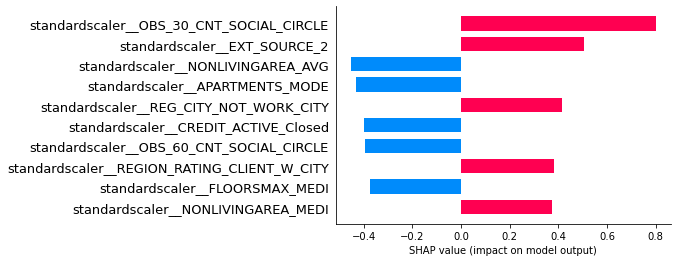

In [125]:
shap.bar_plot(log_reg_explainer.shap_values(X_test_sh[0]),
#               feature_names=boston.feature_names,
              feature_names=shap_feature_names,
#               max_display=len(boston.feature_names))
              max_display=10)

# we see here correlated features, like OBS_30_SOCIAL_CIRCLE and OBS_60_SOCIAL_CIRCLE
# also NONLIVINGAREA_AVG and NONLIVING_AREA_MEDI

In [128]:
# shap.waterfall_plot(log_reg_explainer.expected_value,
#                     log_reg_explainer.shap_values(X_test_sh[0]),
#                     feature_names=shap_feature_names,
#                     max_display=10)
# # TypeError: waterfall() got an unexpected keyword argument 'feature_names'

# # meanwhile, the example code for the classification:
# shap.waterfall_plot(log_reg_explainer.expected_value[1],
#                     log_reg_explainer.shap_values(X_test[0])[1],
#                     feature_names=wine.feature_names,
#                     max_display=len(wine.feature_names)),

# # also, the example code for Linearexplainer for linear regression:
# shap.waterfall_plot(lin_reg_explainer1.expected_value,
#                     lin_reg_explainer1.shap_values(X_test[0]),
#                     feature_names=boston.feature_names,
#                     max_display=len(boston.feature_names))

In [132]:
# shap.waterfall_plot(log_reg_explainer.expected_value,
#                     log_reg_explainer.shap_values(X_test_sh[0]),
#                     max_display=10)
# # TypeError: waterfall() got multiple values for argument 'max_display'

# #  but "max_display" is 10! it's a scalar! which multiple values?

In [133]:
# shap.waterfall_plot(log_reg_explainer.expected_value,
#                     log_reg_explainer.shap_values(X_test_sh[0]))
# # TypeError: waterfall() got multiple values for argument 'max_display'

# # AttributeError: 'numpy.float64' object has no attribute 'base_values'

AttributeError: 'numpy.float64' object has no attribute 'base_values'

Question: how to select the 10 features that I want to see? Not just 10 first. But either the 10 with maximal impact, or 10 specific features that I selected by their names (or indices, but by names is better).

# All the code below is draft code or external code, not a part of the project
## The code examples from internet, without masker
Source: https://coderzcolumn.com/tutorials/machine-learning/shap-explain-machine-learning-model-predictions-using-game-theoretic-approach#classification

In [114]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size=0.85, test_size=0.15, random_state=123, shuffle=True)
lin_reg = LinearRegression()
lin_reg.fit(X_train, Y_train)

import shap
shap.initjs()

lin_reg_explainer1 = shap.LinearExplainer(lin_reg, X_train)
sample_idx = 0
shap_vals = lin_reg_explainer1.shap_values(X_test[sample_idx])

print("Base Value : ", lin_reg_explainer1.expected_value)
print("Shap Values for Sample %d : "%sample_idx, shap_vals)
print("Prediction From Model:", lin_reg.predict(X_test[sample_idx].reshape(1,-1))[0])
print("Prediction From Adding SHAP Values to Base Value:", lin_reg_explainer1.expected_value + shap_vals.sum())

lin_reg_explainer2 = shap.LinearExplainer(lin_reg, X_train, feature_perturbation="correlation_dependent")
sample_idx = 0
shap_vals = lin_reg_explainer2.shap_values(X_test[sample_idx].reshape(1,-1))[0]

print("Base Value : ", lin_reg_explainer2.expected_value)
print("Shap Values for Sample %d : "%sample_idx, shap_vals)
print("Prediction From Model:", lin_reg.predict(X_test[sample_idx].reshape(1,-1))[0])
print("Prediction From Adding SHAP Values to Base Value:", lin_reg_explainer2.expected_value + shap_vals.sum())

NameError: name 'X' is not defined

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size=0.85, test_size=0.15, stratify=Y, random_state=123, shuffle=True)
log_reg = LogisticRegression()
log_reg.fit(X_train, Y_train)

log_reg_explainer = shap.LinearExplainer(log_reg, data=X_train)
sample_idx = 0
shap_vals = log_reg_explainer.shap_values(X_test[sample_idx])
val1 = log_reg_explainer.expected_value[0] + shap_vals[0].sum()
val2 = log_reg_explainer.expected_value[1] + shap_vals[1].sum()
val3 = log_reg_explainer.expected_value[2] + shap_vals[2].sum()

print("Base Value : ", log_reg_explainer.expected_value)
print("Shap Values for Sample %d : "%sample_idx, shap_vals)
print("Prediction From Model:", \ wine.target_names[log_reg.predict(X_test[sample_idx].reshape(1, -1))[0]])
print("Prediction From Adding SHAP Values to Base Value : ", wine.target_names[np.argmax([val1, val2, val3])])

In [ ]:
# We can generate shap values by calling the shap_values() method of explainer object passing it samples 
# for which we want to generate shap values. It'll return 
# a list where each entry is a list of shap values for individual samples passed as data.


# what's the difference of what you put into a shap_values method?
shap.bar_plot(lin_reg_explainer1.shap_values(X_test[0]),
              feature_names=boston.feature_names,
              max_display=len(boston.feature_names))

shap.bar_plot(lin_reg_explainer2.shap_values(X_test[0].reshape(1,-1))[0],
              feature_names=boston.feature_names,
              max_display=len(boston.feature_names))

# same thing again, maybe I should use X_test[0] with independent features and (X_test[0].reshape(1,-1))[0] for correlation dependent ones
shap.waterfall_plot(lin_reg_explainer1.expected_value,
                    lin_reg_explainer1.shap_values(X_test[0]),
                    feature_names=boston.feature_names,
                    max_display=len(boston.feature_names))

shap.waterfall_plot(lin_reg_explainer2.expected_value,
                    lin_reg_explainer2.shap_values(X_test[0].reshape(1,-1))[0],
                    feature_names=boston.feature_names,
                    max_display=len(boston.feature_names))

# same thing again
shap.force_plot(lin_reg_explainer1.expected_value,
                lin_reg_explainer1.shap_values(X_test[0]),
                feature_names=boston.feature_names,
                out_names="Price($)")

shap.force_plot(lin_reg_explainer2.expected_value,
                lin_reg_explainer2.shap_values(X_test[0].reshape(1,-1))[0],
                feature_names=boston.feature_names,
                out_names="Price($)")

# Below we have generated a force plot of 10 samples of the dataset using the first linear explainer. 
# It also provides us with a dropdown on Y-axis which we can change to see the impact of the individual feature on all 
# 10 predictions. In this chart, y-axis values represent predicted values for each sample and the x-axis represents 
# 10 samples from 0-9.
shap.force_plot(lin_reg_explainer1.expected_value,
                lin_reg_explainer1.shap_values(X_test[0:10]),
                feature_names=boston.feature_names,
                out_names="Price($)", figsize=(25,3),
                link="identity")

# Summary Plot is great, available only in linreg_explainer1 but not 2, in 4 variants with different shapes and colors
shap.summary_plot(lin_reg_explainer1.shap_values(X_test),
                  features = X_test,
                  feature_names=boston.feature_names)
shap.summary_plot(lin_reg_explainer1.shap_values(X_test),
                  feature_names=boston.feature_names,
                  plot_type="bar",
                  color="dodgerblue")
shap.summary_plot(lin_reg_explainer1.shap_values(X_test),
                  feature_names=boston.feature_names,
                  plot_type="violin",
                  color="tomato")

In [ ]:
# for the classifications barplots are made separately for every class
shap.bar_plot(log_reg_explainer.shap_values(X_test[0])[0], feature_names=wine.feature_names, max_display=len(wine.feature_names))
shap.bar_plot(log_reg_explainer.shap_values(X_test[0])[1], feature_names=wine.feature_names, max_display=len(wine.feature_names))
shap.bar_plot(log_reg_explainer.shap_values(X_test[0])[2], feature_names=wine.feature_names, max_display=len(wine.feature_names))

# same for waterfall plots
shap.waterfall_plot(log_reg_explainer.expected_value[0],
                    log_reg_explainer.shap_values(X_test[0])[0],
                    feature_names=wine.feature_names,
                    max_display=len(wine.feature_names)),

shap.waterfall_plot(log_reg_explainer.expected_value[1],
                    log_reg_explainer.shap_values(X_test[0])[1],
                    feature_names=wine.feature_names,
                    max_display=len(wine.feature_names)),

shap.waterfall_plot(log_reg_explainer.expected_value[2],
                    log_reg_explainer.shap_values(X_test[0])[2],
                    feature_names=wine.feature_names,
                    max_display=len(wine.feature_names))

# not the same for the decision plot: all the outcomes are on the same chart. note that this is a multioutput decision plot. for 3 classes you'll have 3 lines, for 2 classes as in my case, just 2 lines
shap.multioutput_decision_plot(log_reg_explainer.expected_value.tolist(),
                               log_reg_explainer.shap_values(X_test),
                               row_index=0,
                               feature_names=wine.feature_names,
                               highlight = [1])

# force plot can be for 1 sample or for many: here is for 1 sample
shap.force_plot(log_reg_explainer.expected_value[0],
#                 log_reg_explainer.shap_values(X_test[0])[0],
#                 log_reg_explainer.shap_values(X_test[0])[1],
                log_reg_explainer.shap_values(X_test[0])[2],
                feature_names=wine.feature_names,
                out_names="Wine Type")

# and here is for many
shap.force_plot(log_reg_explainer.expected_value[0],
                log_reg_explainer.shap_values(X_test[:10])[0],
                feature_names=wine.feature_names,
                out_names="Wine Type", figsize=(25,3),
                link="identity")

# shap summary plot can be for multi classes of for only one class: here is for one
shap.summary_plot(log_reg_explainer.shap_values(X_test)[1],
                  features=X_test,
                  feature_names=wine.feature_names)
# and here is for many:
shap.summary_plot(log_reg_explainer.shap_values(X_test),
                  feature_names=wine.feature_names)

# Feature importances for model: global feature importances

For different models the feature importances are extracted with different pieces of code:

For logistic regression: feature importances are given in attribute coef_, and their names are given in n_features_in_ and feature_names_in_

For randomForestClassifier: feature importances are given in attribute n_features_in_ (Number of features seen during fit) and feature_names_in_ Names of features seen during fit. Defined only when X has feature names that are all strings.

As the best model is LogisticRegression, I will train this one again with my personalized metric.
For that I will check with cross-validation to make sure that the best parameters are the same, and take those best parameters learned when refitted with personalized metric.
I will make a new pipeline, this time witout the cross-validation step: I can take the best parameters that 

In [ ]:
# # smaller C means stronger regularization
# # Cs as integer provides equally distributed C from 10^-4 to 10^4
# # model = make_pipeline(preprocessor, LogisticRegression(tol=0.01, max_iter=1000))

# params_to_compare = {'logisticregression__C': np.logspace(-4, 0, 5)}, # (-4, 2, 7)

# model_LogReg_perso, pred_LogReg_perso, perso_params = compare_model(LogisticRegression(class_weight='balanced',
#                                            tol=0.01, 
#                                            max_iter=10_000), 'LogReg', params_to_compare, perso=True)
# #                                            max_iter=10_000), 'LogReg', params_to_compare)

In [ ]:
# model_LogReg_perso # Pipeline(steps=[('columntransformer', 'gridsearchcv')
# model_LogReg_perso[1] # GridSearchCV, estimator=LogisticRegression
# model_LogReg_perso[1].best_params_ # {'C': 0.01}
# model_LogReg_perso[1].estimator # LogisticRegression(class_weight='balanced', max_iter=10000, tol=0.01)
# model_LogReg_perso[1].estimator.coef_ # AttributeError: 'LogisticRegression' object has no attribute 'coef_'

The model doesn't show the coefficients, because Logistic regression wasn't refit. But I have refit it during the gridsearch. How comes? What exactly refits at "refit" step?

In [ ]:
# model_LogReg_perso.n_features_in_ #164
# model_LogReg_perso[1].n_features_in_ #268
# model_LogReg_perso[1].estimator.n_features_in_ # AttributeError: 'LogisticRegression' object has no attribute 'n_features_in_'
# model_LogReg_perso[1].estimator.feature_names_in_ # AttributeError: 'LogisticRegression' object has no attribute 'n_features_in_'

All that looks like the model has been refit, but not the logistic regression.

In [ ]:
# XXX_train = preprocessor.fit_transform(X_train)
# preprocessor # ColumnTransformer(transformers=[('standardscaler', smth...

# clf['preprocessor'].transformers_[1][1]['onehot'].get_feature_names(categorical_features) # sample code from internet
# preprocessor.transformers[1][1].get_feature_names() # NotFittedError: This OneHotEncoder instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.


# preprocessor.fit(X_train) # ColumnTransformer(transformers=[('standardscaler', StandardScaler(), smth...
# preprocessor.get_feature_names_out() # AttributeError: 'ColumnTransformer' object has no attribute 'get_feature_names_out'


# XXX_train.shape
# test_model = LogisticRegression(class_weight='balanced', 
#                                 C=0.01,
#                                 max_iter=10000, tol=0.01)

# test_model.fit(XXX_train, y_train) # LogisticRegression(C=0.01, class_weight='balanced', max_iter=10000, tol=0.01)
# test_model.coef_ # array with shape (1, smth around 200) [[1.3, 3.9, ...]]
# test_model.n_features_in_ # 268
# test_model.feature_names_in_ # AGAIN! AttributeError: 'LogisticRegression' object has no attribute 'feature_names_in_'

feature_names_in_ : Names of features seen during fit. Defined only when X has feature names that are all strings.

Example from https://www.youtube.com/watch?v=NxLfpcfGzns

In [ ]:
# preprocessor2.fit(X_train) # ColumnTransformer(remainder='passthrough', transformers=[('standardscaler', smth...
# preprocessor2.transform(X_test) # ok, array of floats

# preprocessor2.get_feature_names() # AttributeError: Transformer standardscaler (type StandardScaler) does not provide get_feature_names.
# preprocessor2.get_feature_names_out() # YES! array of strings, "standardscaler__SK_ID_CURR", "onehotencoder__CODE_GENDER_F" etc

# preprocessor2.transformers[1][1].get_feature_names() # NotFittedError: This OneHotEncoder instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.
# preprocessor2.transformers[1][1].get_feature_names_out() # NotFittedError: This OneHotEncoder instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.


The discussion on  
https://scikit-learn-enhancement-proposals.readthedocs.io/en/latest/slep007/proposal.html

poses the problem but doesn't offer a resolution. It suggests to add feature_names_in_ attribute and get_feature_names_out method to fitted estimators. But I don't see how to do that.

# Support material: Kernel light GBM Kaggle

 HOME CREDIT DEFAULT RISK COMPETITION
 Most features are created by applying min, max, mean, sum and var functions to grouped tables. 
 Little feature selection is done and overfitting might be a problem since many features are related.
 The following key ideas were used:
 - Divide or subtract important features to get rates (like annuity and income)
 - In Bureau Data: create specific features for Active credits and Closed credits
 - In Previous Applications: create specific features for Approved and Refused applications
 - Modularity: one function for each table (except bureau_balance and application_test)
 - One-hot encoding for categorical features
 All tables are joined with the application DF using the SK_ID_CURR key (except bureau_balance).
 You can use LightGBM with KFold or Stratified KFold.

 Update 16/06/2018:
 - Added Payment Rate feature
 - Removed index from features
 - Use standard KFold CV (not stratified)

In [ ]:
# @contextmanager
# def timer(title):
#     t0 = time()
#     yield
#     print("{} - done in {:.0f}s".format(title, time() - t0))

# # One-hot encoding for categorical columns with get_dummies
# # I don't need the one_hot_encoder function, because I fill the missing values before the pipeline
# def one_hot_encoder(df, nan_as_category = True):
#     original_columns = list(df.columns)
#     categorical_columns = [col for col in df.columns if df[col].dtype == 'object']
#     df = pd.get_dummies(df, columns= categorical_columns, dummy_na= nan_as_category)
#     # имена новых колонок, которые добавились от даммисов. в именах - значения бывших категорийных колонок
#     # точнее у тебя таблица становится меньше, в ней только эти даммисы
#     new_columns = [c for c in df.columns if c not in original_columns]
#     return df, new_columns

# # Preprocess application_train.csv and application_test.csv
# def application_train_test(num_rows = None, nan_as_category = False):
# # Read data
#     df = pd.read_csv(path_csvs + 'application_train.csv', nrows= num_rows)
#     test_df = pd.read_csv(path_csvs + 'application_test.csv', nrows= num_rows)
#     print("Train samples: {}, test samples: {}".format(len(df), len(test_df)))
# # соединяет базы даных с таргетом и без таргета
#     df = df.append(test_df).reset_index()
# # Optional: Remove 4 applications with XNA CODE_GENDER (train set)
#     df = df[df['CODE_GENDER'] != 'XNA']
    
# # Categorical features with Binary encode (0 or 1; two categories)
# # Превращает Y и N в 0 и 1, хотя это же делает OneHotEncoder из SciKitLearn
#     for bin_feature in ['CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY']:
#         df[bin_feature], uniques = pd.factorize(df[bin_feature])
# # Categorical features with One-Hot encode
#     df, cat_cols = one_hot_encoder(df, nan_as_category)
    
# # NaN values for DAYS_EMPLOYED: 365.243 -> nan я сделала то что больше 50,000 дней (136 лет с копейками)
#     df['DAYS_EMPLOYED'].replace(365243, np.nan, inplace= True)
#     # Some simple new features (percentages)
# # improve results of logistic regression, but not the random forest
#     # more precise evaluation of employment
#     df['DAYS_EMPLOYED_PERC'] = df['DAYS_EMPLOYED'] / df['DAYS_BIRTH']
#     # more precise evaluation of employment
#     # evaluation of credit amount taking the income in consideration
#     df['INCOME_CREDIT_PERC'] = df['AMT_INCOME_TOTAL'] / df['AMT_CREDIT']
#     # this is maybe to drop out? doesn't take into account whether both parents work. 
#     # plus, will be highly correlated with number of children in family
#     df['INCOME_PER_PERSON'] = df['AMT_INCOME_TOTAL'] / df['CNT_FAM_MEMBERS']
    
#     # if the annuity is a pension saving, this estimates the saving policy of a client and attitude towards money
#     # if the annuity is a sum to pay per year, it estimates how heavy the burden is
#     df['ANNUITY_INCOME_PERC'] = df['AMT_ANNUITY'] / df['AMT_INCOME_TOTAL']
#     # which part of the whole credit you should pay per year. it's the inverse oy the credit duration in years
#     df['PAYMENT_RATE'] = df['AMT_ANNUITY'] / df['AMT_CREDIT']
#     del test_df
#     gc.collect()
#     return df

# # Сначала категорийные обрабатывает one_hot_encoderом. 
# def bureau_and_balance(num_rows = None, nan_as_category = True):
#     bureau = pd.read_csv(path_csvs + 'bureau.csv', nrows = num_rows)
#     bb = pd.read_csv(path_csvs + 'bureau_balance.csv', nrows = num_rows)
#     bb, bb_cat = one_hot_encoder(bb, nan_as_category)
#     bureau, bureau_cat = one_hot_encoder(bureau, nan_as_category)
    
#     # Bureau balance: Perform aggregations and merge with bureau.csv
#     bb_aggregations = {'MONTHS_BALANCE': ['min', 'max', 'size']}
#     for col in bb_cat:
#         bb_aggregations[col] = ['mean']
#     bb_agg = bb.groupby('SK_ID_BUREAU').agg(bb_aggregations)
#     bb_agg.columns = pd.Index([e[0] + "_" + e[1].upper() for e in bb_agg.columns.tolist()])
#     bureau = bureau.join(bb_agg, how='left', on='SK_ID_BUREAU')
#     bureau.drop(['SK_ID_BUREAU'], axis=1, inplace= True)
#     del bb, bb_agg
#     gc.collect()
    
#     # Bureau and bureau_balance numeric features
#     num_aggregations = {
#         'DAYS_CREDIT': ['min', 'max', 'mean', 'var'],
#         'DAYS_CREDIT_ENDDATE': ['min', 'max', 'mean'],
#         'DAYS_CREDIT_UPDATE': ['mean'],
#         'CREDIT_DAY_OVERDUE': ['max', 'mean'],
#         'AMT_CREDIT_MAX_OVERDUE': ['mean'],
#         'AMT_CREDIT_SUM': ['max', 'mean', 'sum'],
#         'AMT_CREDIT_SUM_DEBT': ['max', 'mean', 'sum'],
#         'AMT_CREDIT_SUM_OVERDUE': ['mean'],
#         'AMT_CREDIT_SUM_LIMIT': ['mean', 'sum'],
#         'AMT_ANNUITY': ['max', 'mean'],
#         'CNT_CREDIT_PROLONG': ['sum'],
#         'MONTHS_BALANCE_MIN': ['min'],
#         'MONTHS_BALANCE_MAX': ['max'],
#         'MONTHS_BALANCE_SIZE': ['mean', 'sum']
#     }
#     # Bureau and bureau_balance categorical features
#     cat_aggregations = {}
#     for cat in bureau_cat: cat_aggregations[cat] = ['mean']
#     for cat in bb_cat: cat_aggregations[cat + "_MEAN"] = ['mean']
    
#     bureau_agg = bureau.groupby('SK_ID_CURR').agg({**num_aggregations, **cat_aggregations})
#     bureau_agg.columns = pd.Index(['BURO_' + e[0] + "_" + e[1].upper() for e in bureau_agg.columns.tolist()])
#     # Bureau: Active credits - using only numerical aggregations
#     active = bureau[bureau['CREDIT_ACTIVE_Active'] == 1]
#     active_agg = active.groupby('SK_ID_CURR').agg(num_aggregations)
#     active_agg.columns = pd.Index(['ACTIVE_' + e[0] + "_" + e[1].upper() for e in active_agg.columns.tolist()])
#     bureau_agg = bureau_agg.join(active_agg, how='left', on='SK_ID_CURR')
#     del active, active_agg
#     gc.collect()
#     # Bureau: Closed credits - using only numerical aggregations
#     closed = bureau[bureau['CREDIT_ACTIVE_Closed'] == 1]
#     closed_agg = closed.groupby('SK_ID_CURR').agg(num_aggregations)
#     closed_agg.columns = pd.Index(['CLOSED_' + e[0] + "_" + e[1].upper() for e in closed_agg.columns.tolist()])
#     bureau_agg = bureau_agg.join(closed_agg, how='left', on='SK_ID_CURR')
#     del closed, closed_agg, bureau
#     gc.collect()
#     return bureau_agg

# # Preprocess previous_applications.csv
# def previous_applications(num_rows = None, nan_as_category = True):
#     prev = pd.read_csv(path_csvs + 'previous_application.csv', nrows = num_rows)
#     prev, cat_cols = one_hot_encoder(prev, nan_as_category= True)
#     # Days 365.243 values -> nan
#     prev['DAYS_FIRST_DRAWING'].replace(365243, np.nan, inplace= True)
#     prev['DAYS_FIRST_DUE'].replace(365243, np.nan, inplace= True)
#     prev['DAYS_LAST_DUE_1ST_VERSION'].replace(365243, np.nan, inplace= True)
#     prev['DAYS_LAST_DUE'].replace(365243, np.nan, inplace= True)
#     prev['DAYS_TERMINATION'].replace(365243, np.nan, inplace= True)
#     # Add feature: value ask / value received percentage
#     prev['APP_CREDIT_PERC'] = prev['AMT_APPLICATION'] / prev['AMT_CREDIT']
#     # Previous applications numeric features
#     num_aggregations = {
#         'AMT_ANNUITY': ['min', 'max', 'mean'],
#         'AMT_APPLICATION': ['min', 'max', 'mean'],
#         'AMT_CREDIT': ['min', 'max', 'mean'],
#         'APP_CREDIT_PERC': ['min', 'max', 'mean', 'var'],
#         'AMT_DOWN_PAYMENT': ['min', 'max', 'mean'],
#         'AMT_GOODS_PRICE': ['min', 'max', 'mean'],
#         'HOUR_APPR_PROCESS_START': ['min', 'max', 'mean'],
#         'RATE_DOWN_PAYMENT': ['min', 'max', 'mean'],
#         'DAYS_DECISION': ['min', 'max', 'mean'],
#         'CNT_PAYMENT': ['mean', 'sum'],
#     }
#     # Previous applications categorical features
#     cat_aggregations = {}
#     for cat in cat_cols:
#         cat_aggregations[cat] = ['mean']
    
#     prev_agg = prev.groupby('SK_ID_CURR').agg({**num_aggregations, **cat_aggregations})
#     prev_agg.columns = pd.Index(['PREV_' + e[0] + "_" + e[1].upper() for e in prev_agg.columns.tolist()])
#     # Previous Applications: Approved Applications - only numerical features
#     approved = prev[prev['NAME_CONTRACT_STATUS_Approved'] == 1]
#     approved_agg = approved.groupby('SK_ID_CURR').agg(num_aggregations)
#     approved_agg.columns = pd.Index(['APPROVED_' + e[0] + "_" + e[1].upper() for e in approved_agg.columns.tolist()])
#     prev_agg = prev_agg.join(approved_agg, how='left', on='SK_ID_CURR')
#     # Previous Applications: Refused Applications - only numerical features
#     refused = prev[prev['NAME_CONTRACT_STATUS_Refused'] == 1]
#     refused_agg = refused.groupby('SK_ID_CURR').agg(num_aggregations)
#     refused_agg.columns = pd.Index(['REFUSED_' + e[0] + "_" + e[1].upper() for e in refused_agg.columns.tolist()])
#     prev_agg = prev_agg.join(refused_agg, how='left', on='SK_ID_CURR')
#     del refused, refused_agg, approved, approved_agg, prev
#     gc.collect()
#     return prev_agg

# # Preprocess POS_CASH_balance.csv
# def pos_cash(num_rows = None, nan_as_category = True):
#     pos = pd.read_csv(path_csvs + 'POS_CASH_balance.csv', nrows = num_rows)
#     pos, cat_cols = one_hot_encoder(pos, nan_as_category= True)
#     # Features
#     aggregations = {
#         'MONTHS_BALANCE': ['max', 'mean', 'size'],
#         'SK_DPD': ['max', 'mean'],
#         'SK_DPD_DEF': ['max', 'mean']
#     }
#     for cat in cat_cols:
#         aggregations[cat] = ['mean']
    
#     pos_agg = pos.groupby('SK_ID_CURR').agg(aggregations)
#     pos_agg.columns = pd.Index(['POS_' + e[0] + "_" + e[1].upper() for e in pos_agg.columns.tolist()])
#     # Count pos cash accounts
#     pos_agg['POS_COUNT'] = pos.groupby('SK_ID_CURR').size()
#     del pos
#     gc.collect()
#     return pos_agg
    
# # Preprocess installments_payments.csv
# def installments_payments(num_rows = None, nan_as_category = True):
#     ins = pd.read_csv(path_csvs + 'installments_payments.csv', nrows = num_rows)
#     ins, cat_cols = one_hot_encoder(ins, nan_as_category= True)
#     # Percentage and difference paid in each installment (amount paid and installment value)
#     ins['PAYMENT_PERC'] = ins['AMT_PAYMENT'] / ins['AMT_INSTALMENT']
#     ins['PAYMENT_DIFF'] = ins['AMT_INSTALMENT'] - ins['AMT_PAYMENT']
#     # Days past due and days before due (no negative values)
#     ins['DPD'] = ins['DAYS_ENTRY_PAYMENT'] - ins['DAYS_INSTALMENT']
#     ins['DBD'] = ins['DAYS_INSTALMENT'] - ins['DAYS_ENTRY_PAYMENT']
#     ins['DPD'] = ins['DPD'].apply(lambda x: x if x > 0 else 0)
#     ins['DBD'] = ins['DBD'].apply(lambda x: x if x > 0 else 0)
#     # Features: Perform aggregations
#     aggregations = {
#         'NUM_INSTALMENT_VERSION': ['nunique'],
#         'DPD': ['max', 'mean', 'sum'],
#         'DBD': ['max', 'mean', 'sum'],
#         'PAYMENT_PERC': ['max', 'mean', 'sum', 'var'],
#         'PAYMENT_DIFF': ['max', 'mean', 'sum', 'var'],
#         'AMT_INSTALMENT': ['max', 'mean', 'sum'],
#         'AMT_PAYMENT': ['min', 'max', 'mean', 'sum'],
#         'DAYS_ENTRY_PAYMENT': ['max', 'mean', 'sum']
#     }
#     for cat in cat_cols:
#         aggregations[cat] = ['mean']
#     ins_agg = ins.groupby('SK_ID_CURR').agg(aggregations)
#     ins_agg.columns = pd.Index(['INSTAL_' + e[0] + "_" + e[1].upper() for e in ins_agg.columns.tolist()])
#     # Count installments accounts
#     ins_agg['INSTAL_COUNT'] = ins.groupby('SK_ID_CURR').size()
#     del ins
#     gc.collect()
#     return ins_agg

# # Preprocess credit_card_balance.csv
# def credit_card_balance(num_rows = None, nan_as_category = True):
#     cc = pd.read_csv(path_csvs + 'credit_card_balance.csv', nrows = num_rows)
#     cc, cat_cols = one_hot_encoder(cc, nan_as_category= True)
#     # General aggregations
#     cc.drop(['SK_ID_PREV'], axis= 1, inplace = True)
#     cc_agg = cc.groupby('SK_ID_CURR').agg(['min', 'max', 'mean', 'sum', 'var'])
#     cc_agg.columns = pd.Index(['CC_' + e[0] + "_" + e[1].upper() for e in cc_agg.columns.tolist()])
#     # Count credit card lines
#     cc_agg['CC_COUNT'] = cc.groupby('SK_ID_CURR').size()
#     del cc
#     gc.collect()
#     return cc_agg

# # LightGBM GBDT with KFold or Stratified KFold
# # Parameters from Tilii kernel: https://www.kaggle.com/tilii7/olivier-lightgbm-parameters-by-bayesian-opt/code
# def kfold_lightgbm(df, num_folds, stratified = False, debug= False):
#     # Divide in training/validation and test data
#     train_df = df[df['TARGET'].notnull()]
#     test_df = df[df['TARGET'].isnull()]
#     print("Starting LightGBM. Train shape: {}, test shape: {}".format(train_df.shape, test_df.shape))
#     del df
#     gc.collect()
#     # Cross validation model
#     if stratified:
#         folds = StratifiedKFold(n_splits= num_folds, shuffle=True, random_state=1001)
#     else:
#         folds = KFold(n_splits= num_folds, shuffle=True, random_state=1001)
#     # Create arrays and dataframes to store results
#     oof_preds = np.zeros(train_df.shape[0])
#     sub_preds = np.zeros(test_df.shape[0])
#     feature_importance_df = pd.DataFrame()
#     feats = [f for f in train_df.columns if f not in ['TARGET','SK_ID_CURR','SK_ID_BUREAU','SK_ID_PREV','index']]
    
#     for n_fold, (train_idx, valid_idx) in enumerate(folds.split(train_df[feats], train_df['TARGET'])):
#         train_x, train_y = train_df[feats].iloc[train_idx], train_df['TARGET'].iloc[train_idx]
#         valid_x, valid_y = train_df[feats].iloc[valid_idx], train_df['TARGET'].iloc[valid_idx]

#         # LightGBM parameters found by Bayesian optimization
#         clf = LGBMClassifier(
#             nthread=4,
#             n_estimators=10000,
#             learning_rate=0.02,
#             num_leaves=34,
#             colsample_bytree=0.9497036,
#             subsample=0.8715623,
#             max_depth=8,
#             reg_alpha=0.041545473,
#             reg_lambda=0.0735294,
#             min_split_gain=0.0222415,
#             min_child_weight=39.3259775,
#             silent=-1,
#             verbose=-1, )

#         clf.fit(train_x, train_y, eval_set=[(train_x, train_y), (valid_x, valid_y)], 
#             eval_metric= 'auc', verbose= 200, early_stopping_rounds= 200)  # here lightgbm error

#         oof_preds[valid_idx] = clf.predict_proba(valid_x, num_iteration=clf.best_iteration_)[:, 1]
#         sub_preds += clf.predict_proba(test_df[feats], num_iteration=clf.best_iteration_)[:, 1] / folds.n_splits

#         fold_importance_df = pd.DataFrame()
#         fold_importance_df["feature"] = feats
#         fold_importance_df["importance"] = clf.feature_importances_
#         fold_importance_df["fold"] = n_fold + 1
#         feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
#         print('Fold %2d AUC : %.6f' % (n_fold + 1, roc_auc_score(valid_y, oof_preds[valid_idx])))
#         del clf, train_x, train_y, valid_x, valid_y
#         gc.collect()

#     print('Full AUC score %.6f' % roc_auc_score(train_df['TARGET'], oof_preds))
#     # Write submission file and plot feature importance
#     if not debug:
#         test_df['TARGET'] = sub_preds
#         test_df[['SK_ID_CURR', 'TARGET']].to_csv(submission_file_name, index= False)
#     display_importances(feature_importance_df)
#     return feature_importance_df

# # Display/plot feature importance
# def display_importances(feature_importance_df_):
#     cols = feature_importance_df_[["feature", "importance"]].groupby("feature").mean().sort_values(by="importance", ascending=False)[:40].index
#     best_features = feature_importance_df_.loc[feature_importance_df_.feature.isin(cols)]
#     plt.figure(figsize=(8, 10))
#     sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False))
#     plt.title('LightGBM Features (avg over folds)')
#     plt.tight_layout()
#     plt.savefig('lgbm_importances01.png')


# def main(debug = False):
#     num_rows = 10000 if debug else None
#     df = application_train_test(num_rows)
#     with timer("Process bureau and bureau_balance"):
#         bureau = bureau_and_balance(num_rows)
#         print("Bureau df shape:", bureau.shape)
#         df = df.join(bureau, how='left', on='SK_ID_CURR')
#         del bureau
#         gc.collect()
#     with timer("Process previous_applications"):
#         prev = previous_applications(num_rows)
#         print("Previous applications df shape:", prev.shape)
#         df = df.join(prev, how='left', on='SK_ID_CURR')
#         del prev
#         gc.collect()
#     with timer("Process POS-CASH balance"):
#         pos = pos_cash(num_rows)
#         print("Pos-cash balance df shape:", pos.shape)
#         df = df.join(pos, how='left', on='SK_ID_CURR')
#         del pos
#         gc.collect()
#     with timer("Process installments payments"):
#         ins = installments_payments(num_rows)
#         print("Installments payments df shape:", ins.shape)
#         df = df.join(ins, how='left', on='SK_ID_CURR')
#         del ins
#         gc.collect()
#     with timer("Process credit card balance"):
#         cc = credit_card_balance(num_rows)
#         print("Credit card balance df shape:", cc.shape)
#         df = df.join(cc, how='left', on='SK_ID_CURR')
#         del cc
#         gc.collect()
#     return df
# #     with timer("Run LightGBM with kfold"):
# #         feat_importance = kfold_lightgbm(df, num_folds= 10, stratified= False, debug= debug)

In [ ]:
# test_df = main(debug=True)
# test_df.shape

In [ ]:
# def compare_model(my_estimator, model_name, my_params={}, smote=False, perso=False):
# # def compare_model(my_estimator, model_name, my_params={}, perso=False):
    
# #     if smote:
# #         oversample = SMOTE()
# #         X_train, y_train = oversample.fit_resample(X_train, y_train)
    
#     if not perso:
#         scoring = ['roc_auc', 'recall', 'precision']
#         refit='roc_auc'
# #         refit=False # AttributeError: 'GridSearchCV' object has no attribute 'best_params_'. For multi-metric evaluation, best_params_ is present only if refit is specified
#     else:
#         scoring = my_scoring # my_scorer, also works, if you uncomment the line
#         refit='perso'
# #         refit='roc_auc' # temporary for debugging, to show that the problem isn't in the metric or scorer
# #         refit=my_scoring['perso'] #TypeError: __call__() missing 2 required positional arguments: 'X' and 'y_true'

#     if not smote:
#         model = make_pipeline(preprocessor, 
#                 GridSearchCV(
#                           estimator=my_estimator, 
#                           param_grid=my_params, 
#                           cv=5, 
#                           scoring=scoring, 
# #                           scoring='roc_auc', 
#                           return_train_score = True, 
#                           refit=refit, #'roc_auc', 
#                           n_jobs = -1
#                       ))

    
#     else:
#         model = GridSearchCV(
#                           estimator=my_estimator, 
#                           param_grid=my_params, 
#                           cv=5, 
#                           scoring=scoring, 
# #                           scoring='roc_auc', 
#                           return_train_score = True, 
#                           refit=refit, #'roc_auc', 
#                           n_jobs = -1
#                       )
    
#     time1 = time()
#     print('Fitting started')
# #     model.fit(X_train, y_train)
#     model = model.fit(X_train, y_train)
#     time2 = time()
#     print('Cross-validation of model', model_name, 'completed in', time2 - time1, 'seconds')
#     print('best params:', model[1].best_params_)
#     results = model[1].cv_results_
    
#     y_pred = model.predict(X_test)

#     if not perso:
#         my_list = errors
#     else:
#         my_list = perso_errors
    
#     my_list.append([model_name, 'cv_train', smote,
#                round(results['mean_train_roc_auc'].max(), 3),
#                round(results['mean_train_recall'].max(), 3),
#                round(results['mean_train_precision'].max(), 3)])

#     my_list.append([model_name, 'cv_test', smote,
#                round(results['mean_test_roc_auc'].max(), 3),
#                round(results['mean_test_recall'].max(), 3),
#                round(results['mean_test_precision'].max(), 3)])

#     my_list.append([model_name, 'external_test', smote,
#                round(roc_auc_score(y_test, y_pred), 3),
#                round(recall_score(y_test, y_pred), 3),
#                round(precision_score(y_test, y_pred), 3)])
#     if perso:
#         print('train AUC', results['mean_train_roc_auc'].max(), 'test AUC', results['mean_test_roc_auc'].max(), 
#               'train perso', results['mean_train_perso'].max(), 'test perso', results['mean_test_perso'].max())


#     time3 = time()
#     print('Prediction and appending completed in', time3 - time2, 'seconds')
#     if not perso:
#         return model, y_pred#, model[1].best_params_
#     else:
#         return model, y_pred, model[1].best_params_
    

In [ ]:
# oversample = imblearn.over_sampling.SMOTE()
# X_train_smote = preprocessor.fit_transform(X_train)
# X_train_smote, y_train_smote = oversample.fit_resample(X_train_smote, y_train)

In [ ]:
# x, dummy_pred = compare_model(DummyClassifier(strategy='prior'), 'Dummy', smote=True) # TypeError: 'GridSearchCV' object is not subscriptable
# need to deal with the fact that now the pipeline consists of only 1 step, GridSearch, and not 2, preprocessor and Gridseaarch, as before

In [ ]:
# def compare_model(my_estimator, model_name, my_params={}, smote=False, perso=False):
    
#     if smote:
# #         model = make_pipeline(preprocessor, SMOTE(random_state=rasta_smote), my_estimator) # TypeError: All intermediate steps should be transformers and implement fit and transform or be the string 'passthrough' 'SMOTE(random_state=1)' (type <class 'imblearn.over_sampling._smote.base.SMOTE'>) doesn't
#         model = make_pipeline_imblearn(preprocessor, SMOTE(random_state=rasta_smote), my_estimator)
#     else:
#         model = make_pipeline(preprocessor, my_estimator)
#         print(model)

#     if perso:
#         scoring = my_scoring # my_scorer, also works, if you uncomment the line. search "my_scorer ="
#         refit='perso'
# #         refit='roc_auc' # temporary for debugging, to show that the problem isn't in the metric or scorer
# #         refit=my_scoring['perso'] #TypeError: __call__() missing 2 required positional arguments: 'X' and 'y_true'

#     else:
#         scoring = ['roc_auc', 'recall', 'precision']
#         refit='roc_auc'
# #         refit=False # AttributeError: 'GridSearchCV' object has no attribute 'best_params_'. For multi-metric evaluation, best_params_ is present only if refit is specified

#     grid = GridSearchCV(
# #                       estimator=my_estimator, 
# #                       estimator=model,
#                       model,
#                       param_grid=my_params, 
#                       cv=5, 
#                       scoring=scoring, 
# #                           scoring='roc_auc', 
#                       return_train_score = True, 
#                       refit=refit, #'roc_auc', 
#                       n_jobs = -1)
    
#     time1 = time()
#     print('Fitting started')
# #     model.fit(X_train, y_train)
# #     model = model.fit(X_train, y_train)
#     grid = grid.fit(X_train, y_train)
#     time2 = time()
#     print('Cross-validation of model', model_name, 'completed in', time2 - time1, 'seconds')
# #     print('best params:', model[1].best_params_)
#     print('best params:', grid.best_params_)
# #     results = model[1].cv_results_
#     results = grid.cv_results_
    
# #     y_pred = model.predict(X_test) # NotFittedError: This ColumnTransformer instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.
#     y_pred = grid.predict(X_test)
    
#     if perso:
#         my_metric = results['mean_train_perso'].max()
#     else:
#         my_metric = np.nan

#     errors.append([model_name, 'cv_train', smote, perso,
# #                round(results['mean_train_roc_auc'].max(), 3),
#                my_metric,
#                results['mean_train_roc_auc'].max().round(3),
#                round(results['mean_train_recall'].max(), 3),
#                round(results['mean_train_precision'].max(), 3)])

#     if perso:
#         my_metric = results['mean_test_perso'].max()

#     errors.append([model_name, 'cv_test', smote, perso,
#                my_metric,
#                round(results['mean_test_roc_auc'].max(), 3),
#                round(results['mean_test_recall'].max(), 3),
#                round(results['mean_test_precision'].max(), 3)])

#     if perso:
#         my_metric = round(personalized_metric(y_test, y_pred), 3)

#     errors.append([model_name, 'external_test', smote, perso,
#                my_metric,
#                round(roc_auc_score(y_test, y_pred), 3),
#                round(recall_score(y_test, y_pred), 3),
#                round(precision_score(y_test, y_pred), 3),
#                   ])
    
#     time3 = time()
#     print('Prediction and evaluation completed in', time3 - time2, 'seconds')
    
#     return model, y_pred, grid.best_params_
    